In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("asludds")
from scipy.optimize import newton
from tqdm import tqdm

from SOA_model import SOA

def dB2val(x):
    return 10**(x/10)

def val2dB(x):
    return 10*np.log10(x)


T = 35, lambda_peak = 1290.8402434521206 (nm), FWHM = 64.58325537632304 (nm), gpeak = 11.998668546818102 (dB)
T = 55, lambda_peak = 1298.2597330645624 (nm), FWHM = 70.50578909445856 (nm), gpeak = 10.423939605003781 (dB)
T = 70, lambda_peak = 1306.231475273894 (nm), FWHM = 74.98855538306019 (nm), gpeak = 9.116892898643037 (dB)
T = 80, lambda_peak = 1312.6922200801148 (nm), FWHM = 77.99652624212797 (nm), gpeak = 8.185528427735875 (dB)


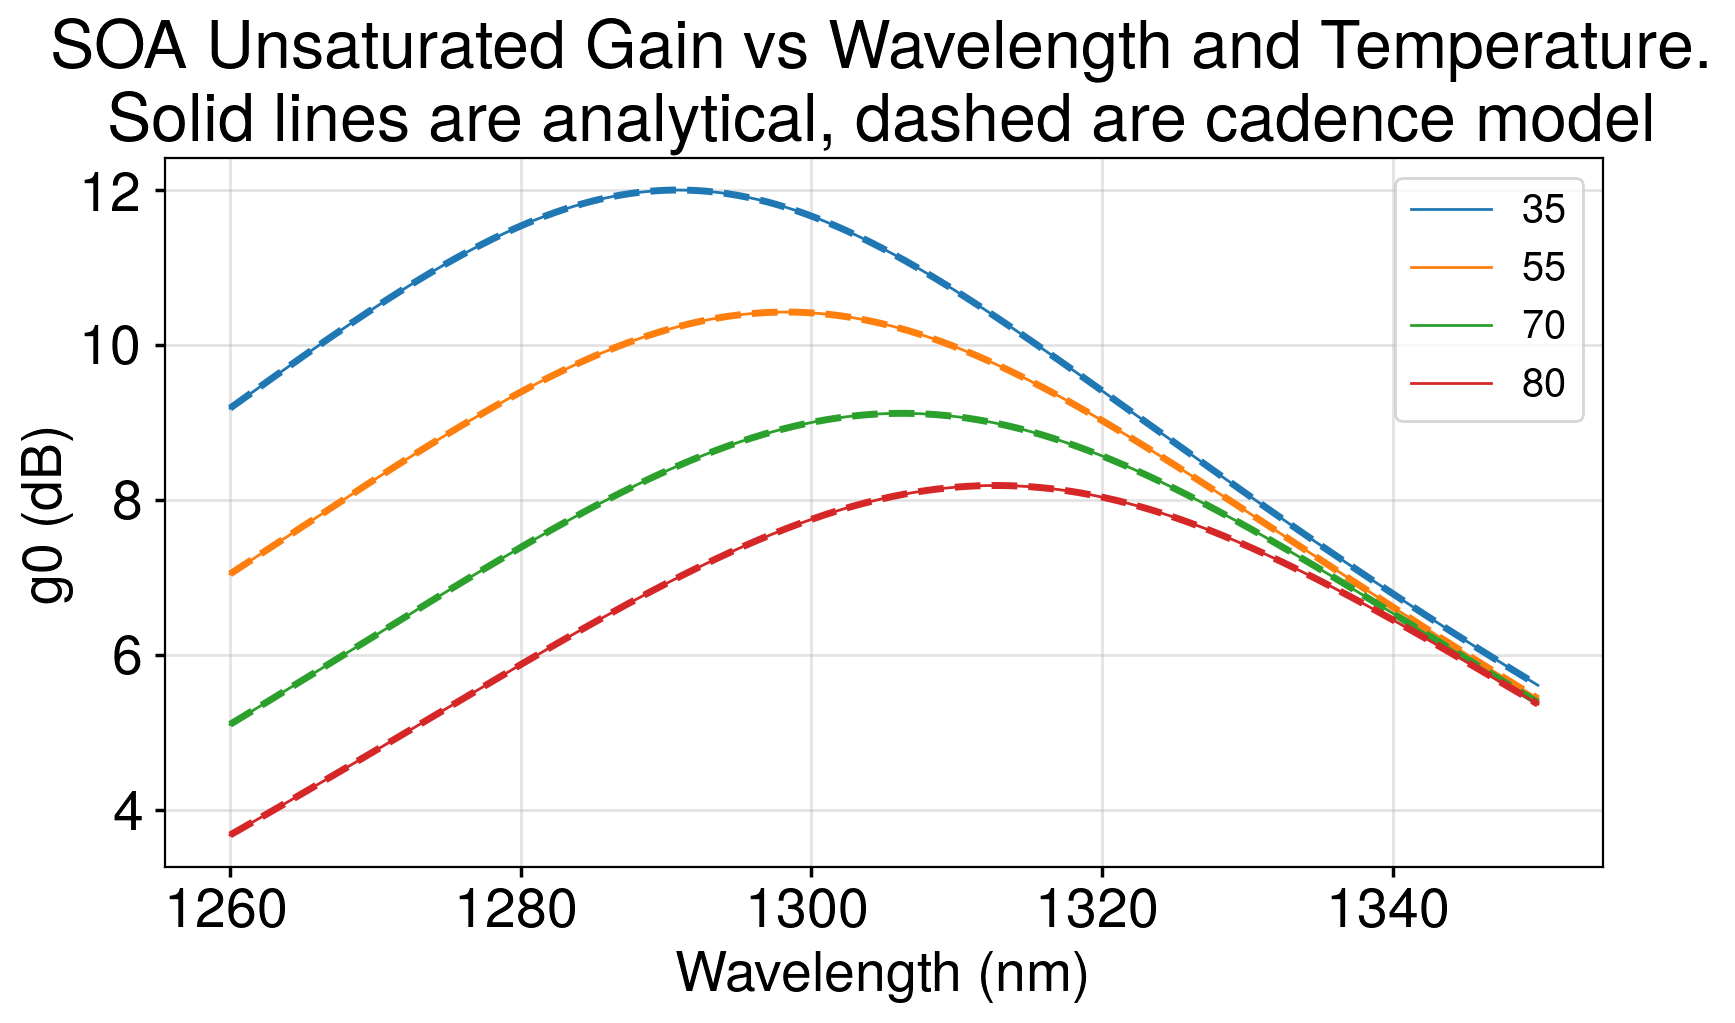

<Figure size 1600x1000 with 0 Axes>

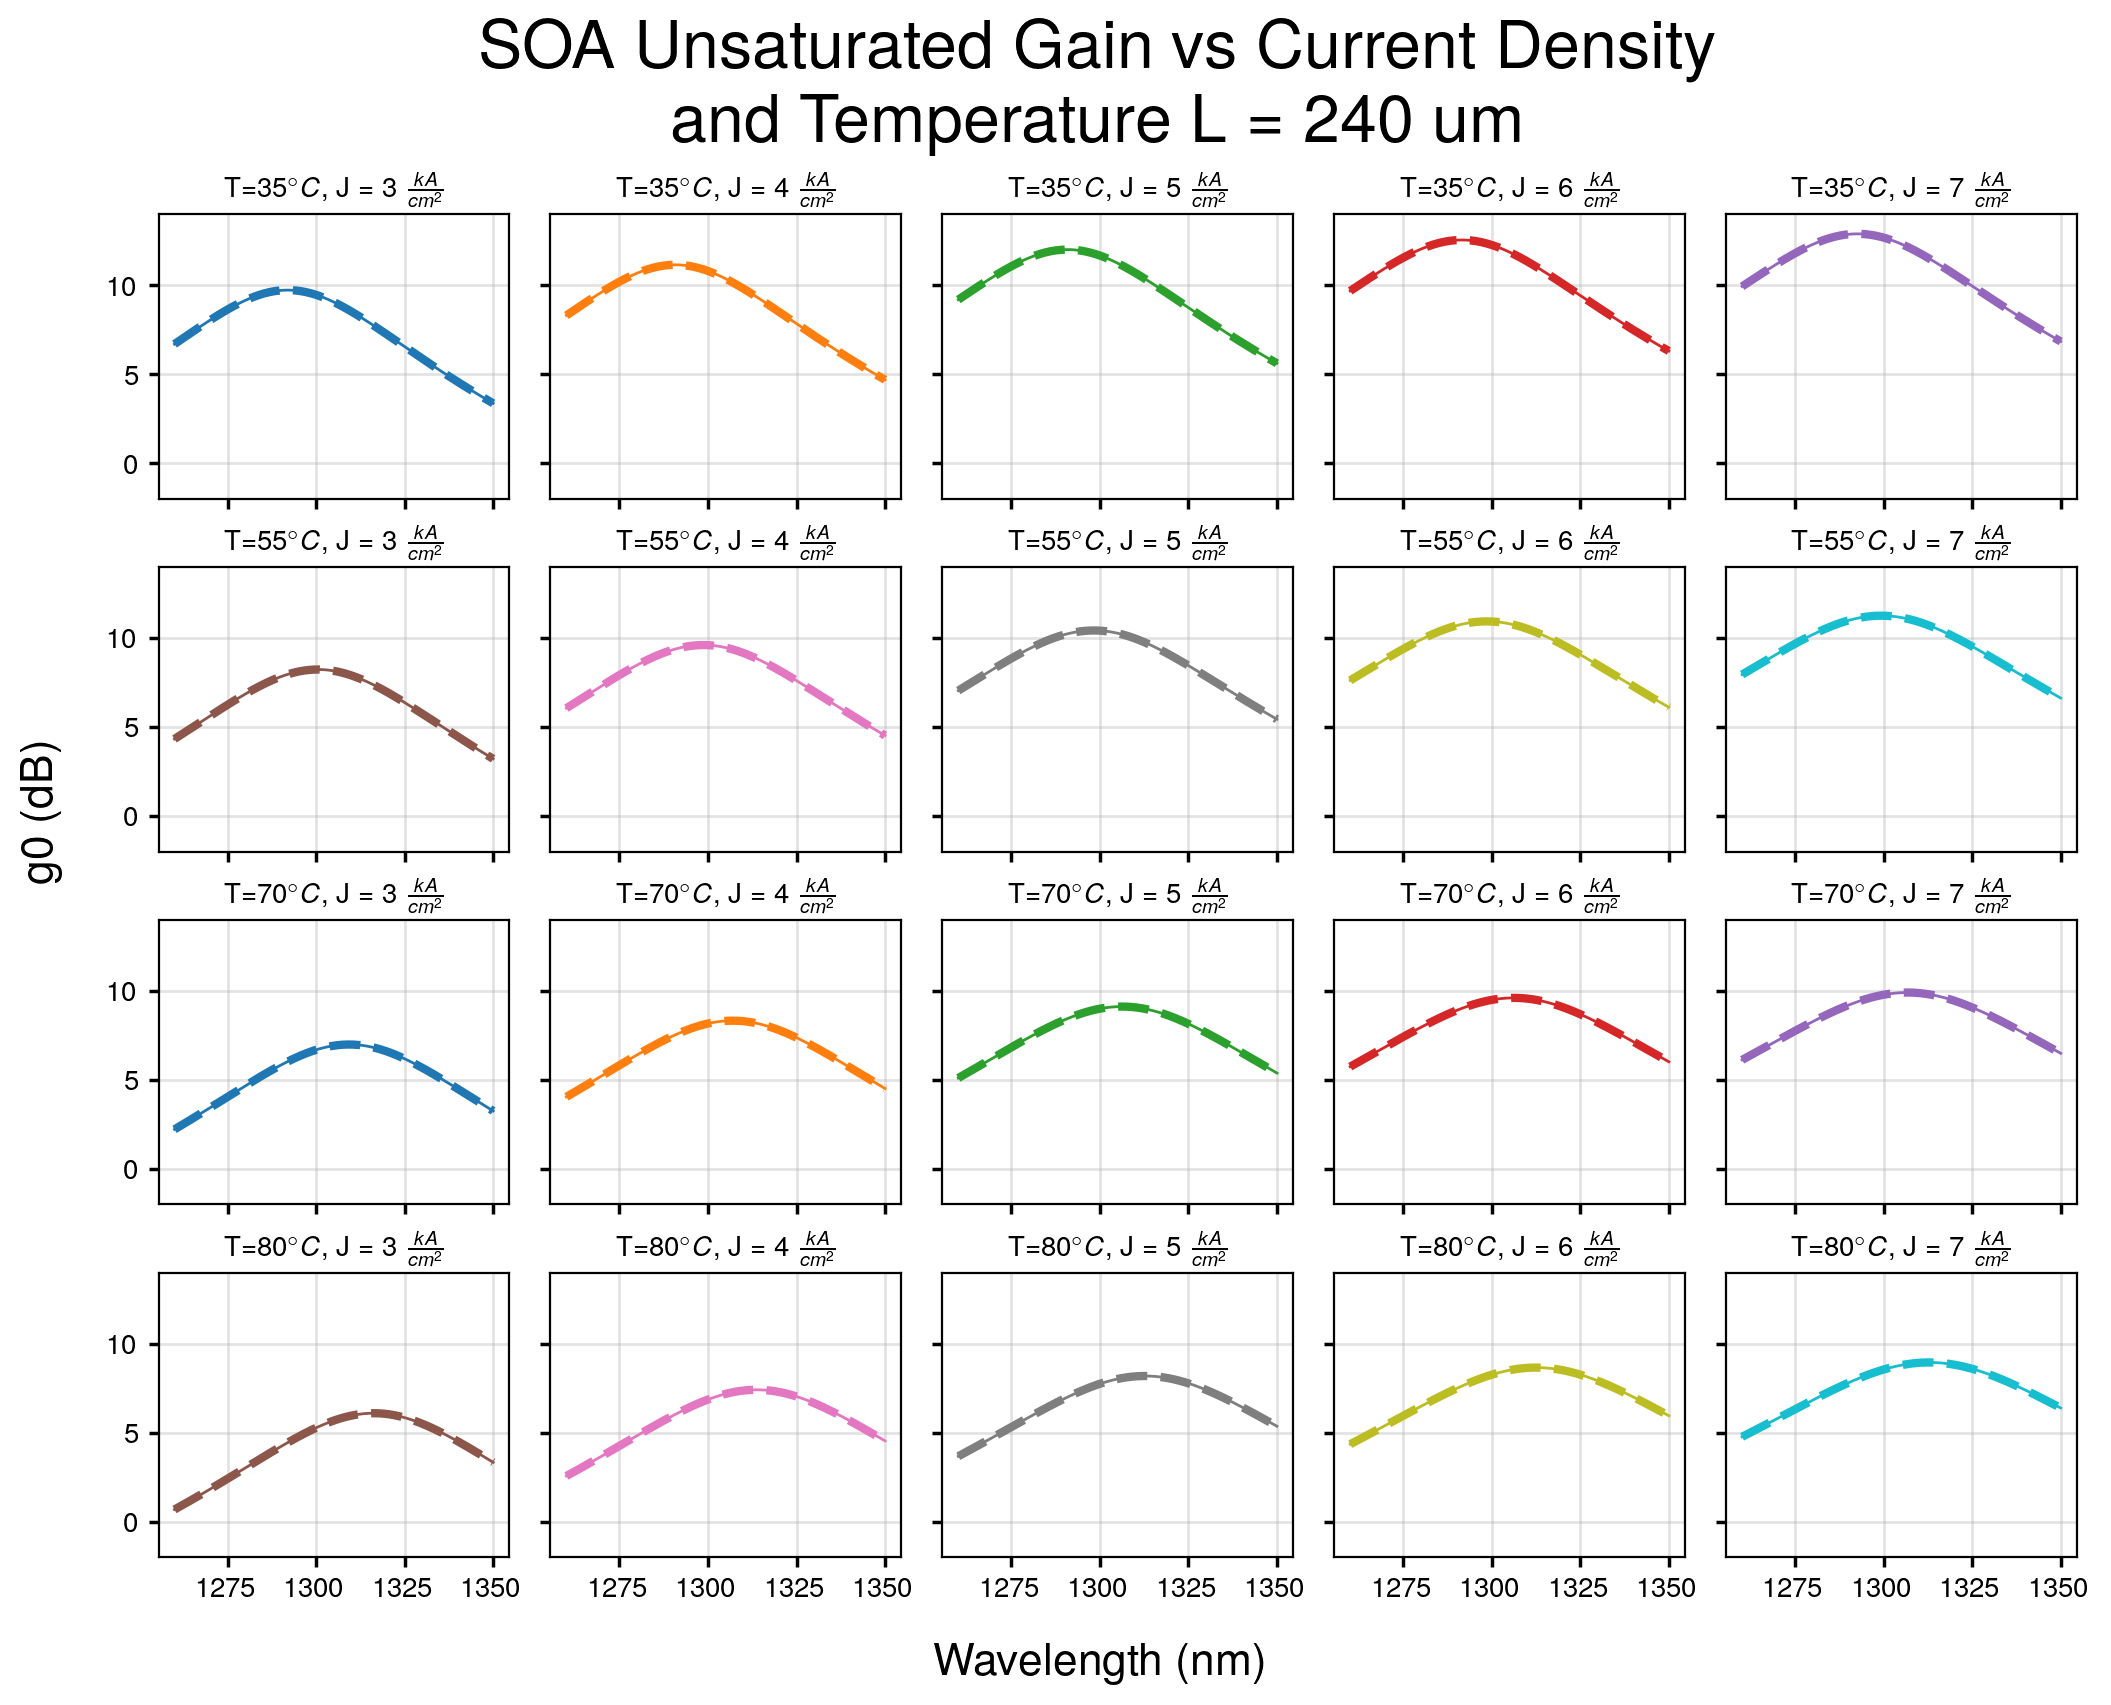

In [2]:
#Debug individual equations.
#First, let's look at g0
L = 240
J = 5
T_sweep = [35,55,70,80]

import pandas as pd

cadence_data = pd.read_csv("Model_Data/g0_dB_vs_wav_and_temp.csv").to_numpy()

plt.figure()
lambda_sweep = np.linspace(1260,1350,num=1000)
for T_index,T in enumerate(T_sweep):
    g0_sweep = []
    for x in lambda_sweep:
        tmp = SOA(T,J,L,x)
        g0_sweep.append(tmp.g0)
    g0_sweep = np.array(g0_sweep)
    # g0_sweep = np.array([g0(x,T,J,L) for x in lambda_sweep])
    g0_sweep_dB = 10*np.log10(g0_sweep)
    plt.plot(lambda_sweep,g0_sweep_dB,c=f"C{T_index}",linewidth=1)
    plt.plot(cadence_data[:,2*T_index]*1e9,cadence_data[:,2*T_index+1],c=f"C{T_index}",linestyle='--',label='_nolegend_')
    print(f"T = {T}, lambda_peak = {tmp.wavelength_peak} (nm), FWHM = {tmp.FWHM} (nm), gpeak = {tmp.gain_peak} (dB)")
plt.legend(T_sweep)
plt.xlabel("Wavelength (nm)")
plt.ylabel("g0 (dB)")
plt.title("SOA Unsaturated Gain vs Wavelength and Temperature. \n Solid lines are analytical, dashed are cadence model")
plt.show()

data = pd.read_csv("Model_Data/g_dB_vs_T_J.csv").to_numpy()

#Create plot of J vs T in 2D sweep
J_sweep = [3,4,5,6,7]
T_sweep = [35,55,70,80]
plt.figure()
fig, axs = plt.subplots(nrows=4,ncols=5,sharex=True,sharey=True,figsize=(10,8))
for Jindex, J in enumerate(J_sweep):
    for Tindex, T in enumerate(T_sweep):
        g0_sweep = []
        for x in lambda_sweep:
            tmp = SOA(T,J,L,x)
            g0_sweep.append(tmp.g0)
        g0_sweep = np.array(g0_sweep)
        g0_sweep_dB = 10*np.log10(g0_sweep)
        temp = len(J_sweep)*Tindex + Jindex
        axs[Tindex,Jindex].plot(lambda_sweep,g0_sweep_dB,c=f'C{temp}',linewidth=1)
        axs[Tindex,Jindex].set_ylim(-2,14)
        axs[Tindex,Jindex].tick_params(axis='both', which='major', labelsize=10)
        axs[Tindex,Jindex].set_title(f"T={T}" + r"$^{\circ} C$" + f", J = {J} " + r"$\frac{kA}{cm^{2}}$",fontsize=10)

        
        x = data[:,2*temp]
        y = data[:,2*temp+1]
        axs[Tindex,Jindex].plot(x*1e9,y,c=f'C{temp}',linestyle='--',linewidth=3,label='_nolegend_',zorder=100)
fig.text(0.5, -0.04, 'Wavelength (nm)', ha='center',fontsize=16)
fig.text(-0.04, 0.5, 'g0 (dB)', va='center', rotation='vertical',fontsize=16)
plt.suptitle(f"SOA Unsaturated Gain vs Current Density \n and Temperature L = {L} um")
plt.show()

Text(0, 0.5, 'g (dB)')

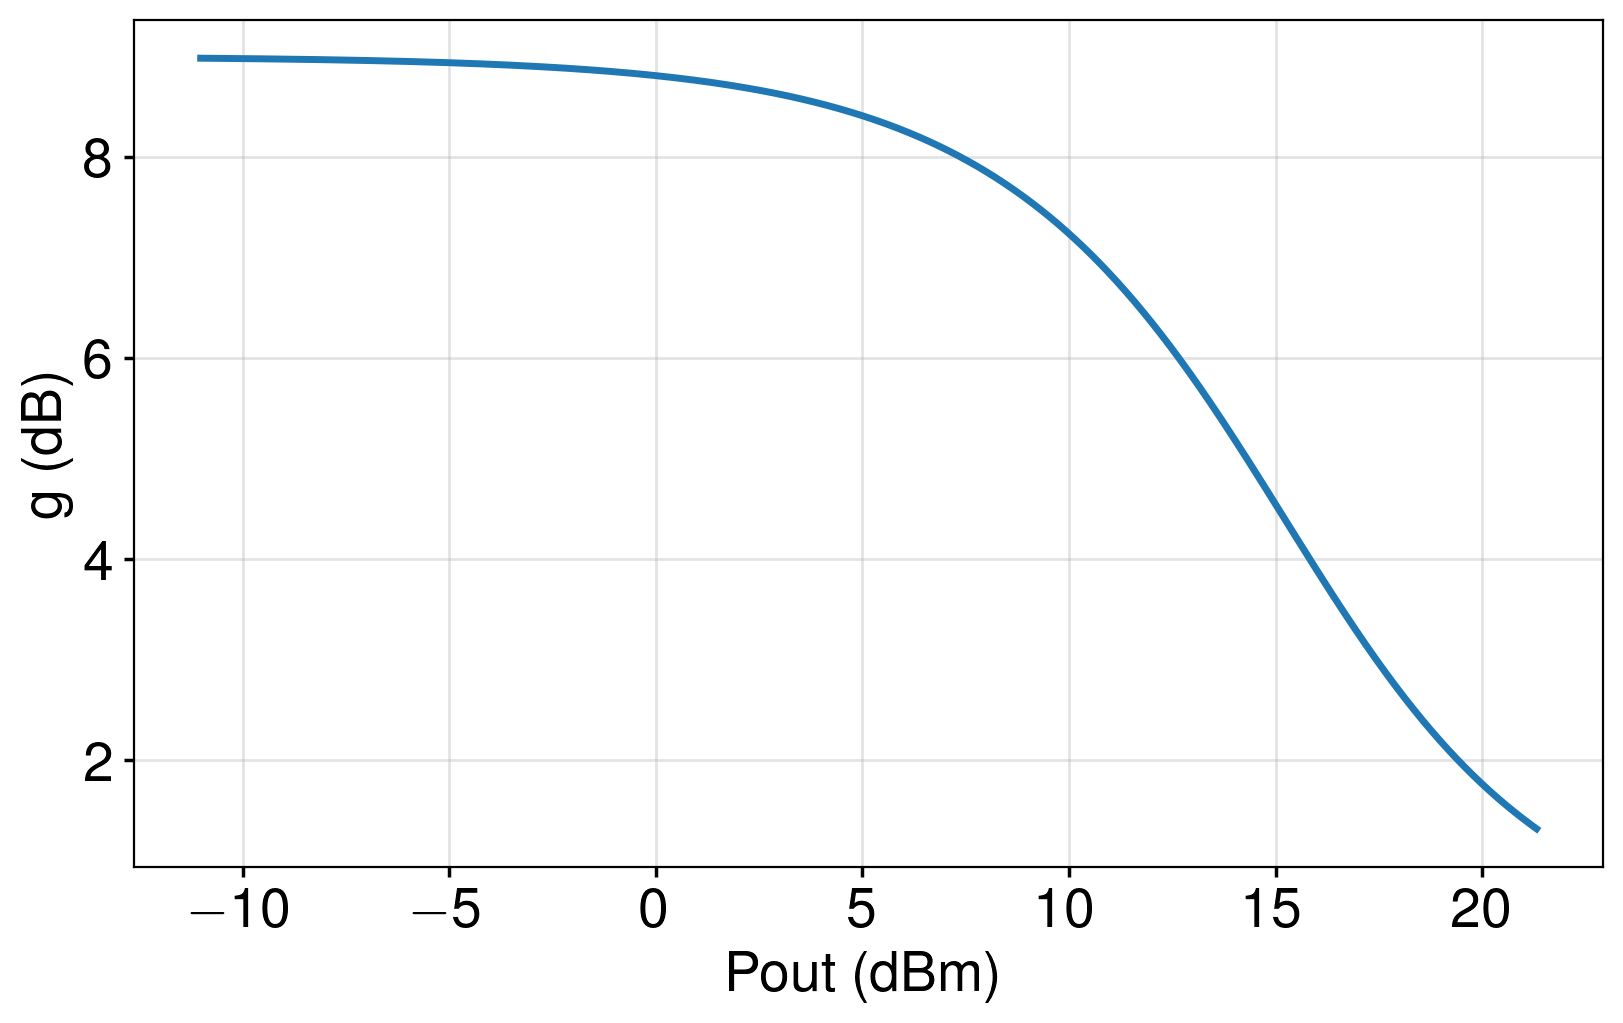

In [3]:
# Plot gain vs. output power (dBm)
# SOA parameters
Pin_sweep = np.logspace(-5,-1,base=10,num=1000) #Sweep in logspace
g0_ = 10**(9/10)
Ps_ = 20e-3
g_storage = []
for Pin in Pin_sweep:
    def f(g):
        return g - g0_ * np.exp((1-g) * Pin/Ps_)

    def fprime(g):
        z = Pin/Ps_
        return 1 + g0_ * z * np.exp(z*(1-g))

    g_storage.append(newton(f, g0_, fprime=fprime, maxiter=1000))

g_storage = np.array(g_storage)
g_storage_dB = 10*np.log10(g_storage)
Pout_sweep_W = np.multiply(g_storage,Pin_sweep)
Pout_sweep_mW = Pout_sweep_W*1e3
Pout_sweep_dBm = 10*np.log10(Pout_sweep_mW)
plt.figure()
plt.plot(Pout_sweep_dBm,g_storage_dB)
plt.xlabel("Pout (dBm)")
plt.ylabel("g (dB)")

<Figure size 1600x1000 with 0 Axes>

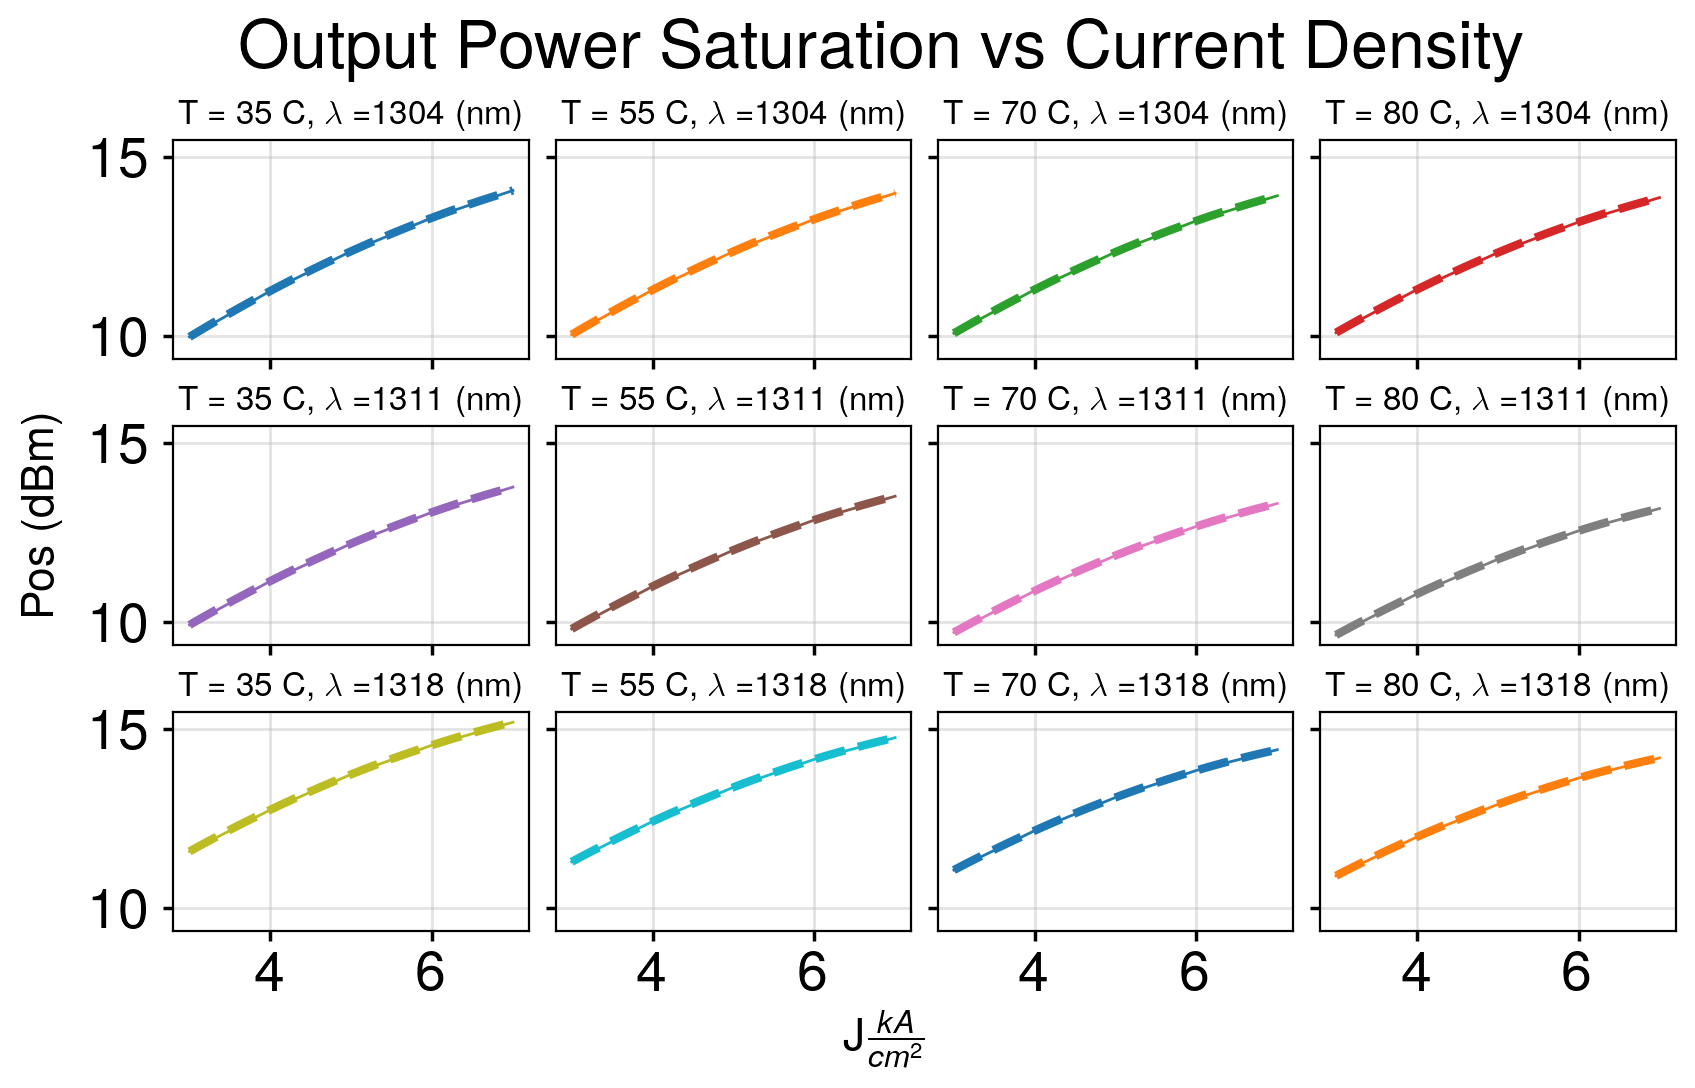

In [4]:
#Create plot of J vs T in 2D sweep
J_sweep = [3,4,5,6,7]
T_sweep = [35,55,70,80]
lam_short_sweep = [1304,1311,1318]

data = pd.read_csv("Model_Data/Pos_dBm_vs_wl_and_T.csv").to_numpy()
    
plt.figure()
fig, axs = plt.subplots(nrows=3,ncols=4,sharex=True,sharey=True)
for Lambda_index, Lambda in enumerate(lam_short_sweep):
    T_counter = 0
    for Tindex, Tvalue in enumerate(T_sweep):
        Pos_sweep = []
        for J in J_sweep:
            tmp = SOA(Tvalue,J,400,Lambda)
            Pos_sweep.append(tmp.Pos_3dB)
        Pos_sweep = np.array(Pos_sweep)
        temp = len(T_sweep)*Lambda_index + T_counter
        
        axs[Lambda_index,Tindex].plot(J_sweep,Pos_sweep,c=f'C{temp}',linewidth=1)
        axs[Lambda_index,Tindex].set_title(f"T = {Tvalue} C, " + r"$\lambda = $" + f"{Lambda} (nm)",fontsize=12)
        axs[Lambda_index,Tindex].plot(data[:,2*temp],data[:,2*temp+1],c=f'C{temp}',linestyle='--',linewidth=3,label='_nolegend_',zorder=100)
        # axs[Tindex,Lambda_index].set_ylim(-2,14)
        T_counter += 1
fig.text(0.5, -0.04, 'J' + r"$\frac{kA}{cm^{2}}$", ha='center',fontsize=16)
fig.text(-0.04, 0.5, 'Pos (dBm)', va='center', rotation='vertical',fontsize=16)
plt.suptitle("Output Power Saturation vs Current Density")
plt.show()

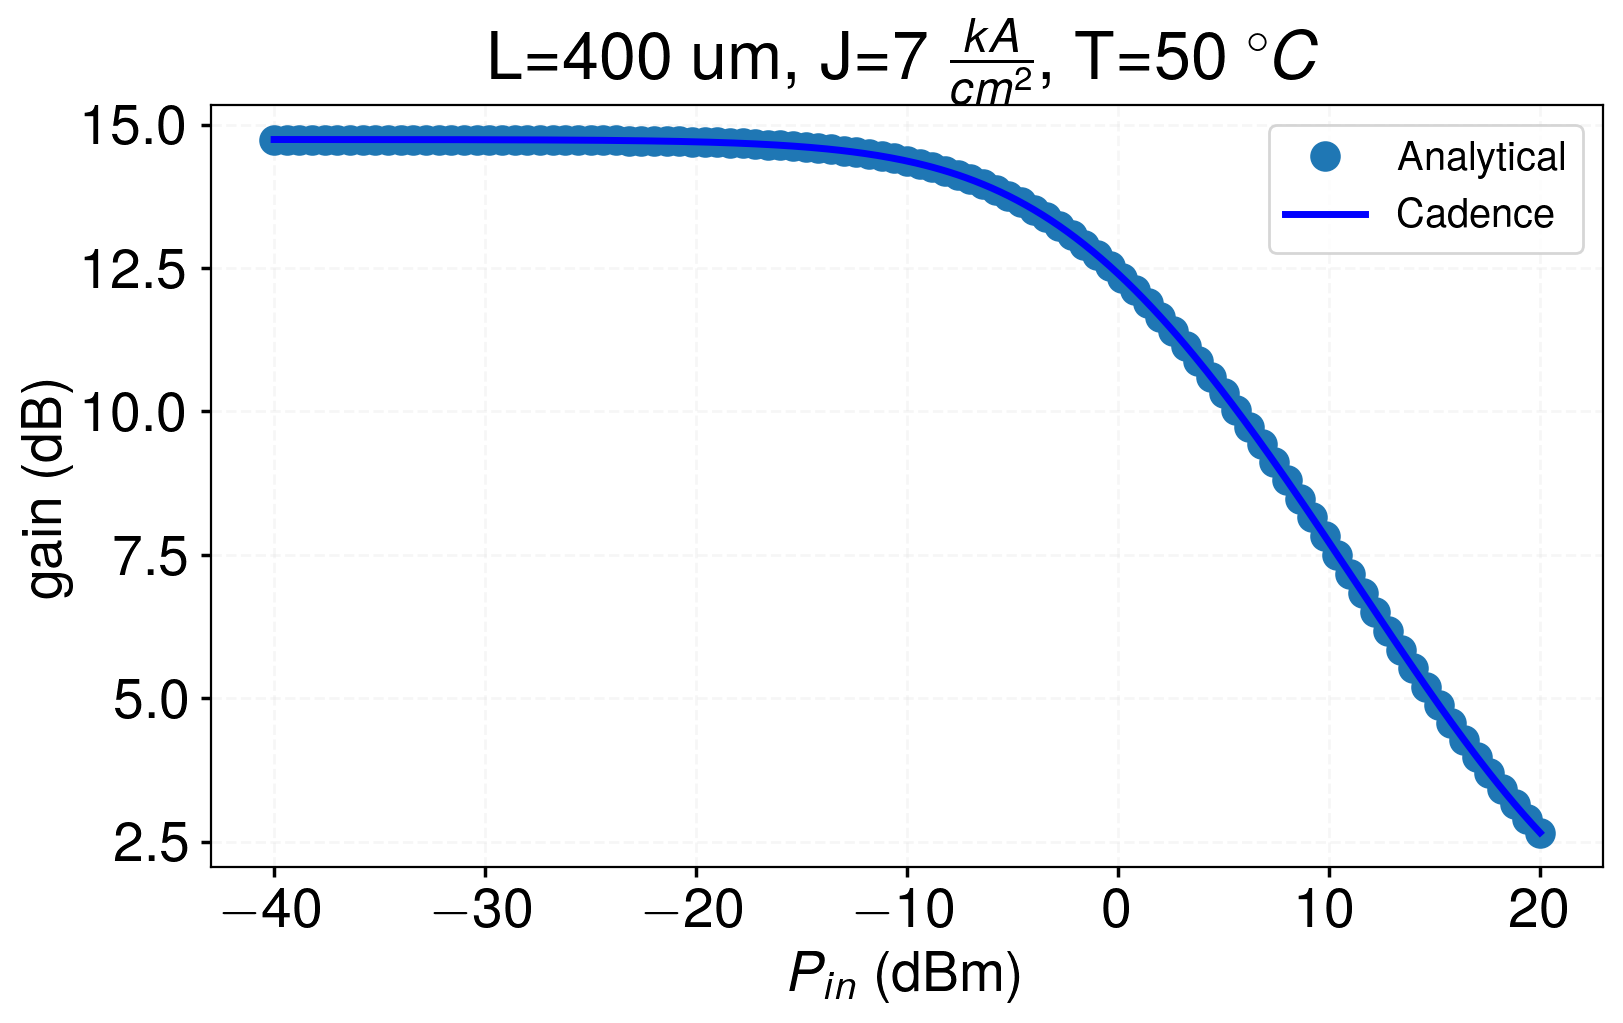

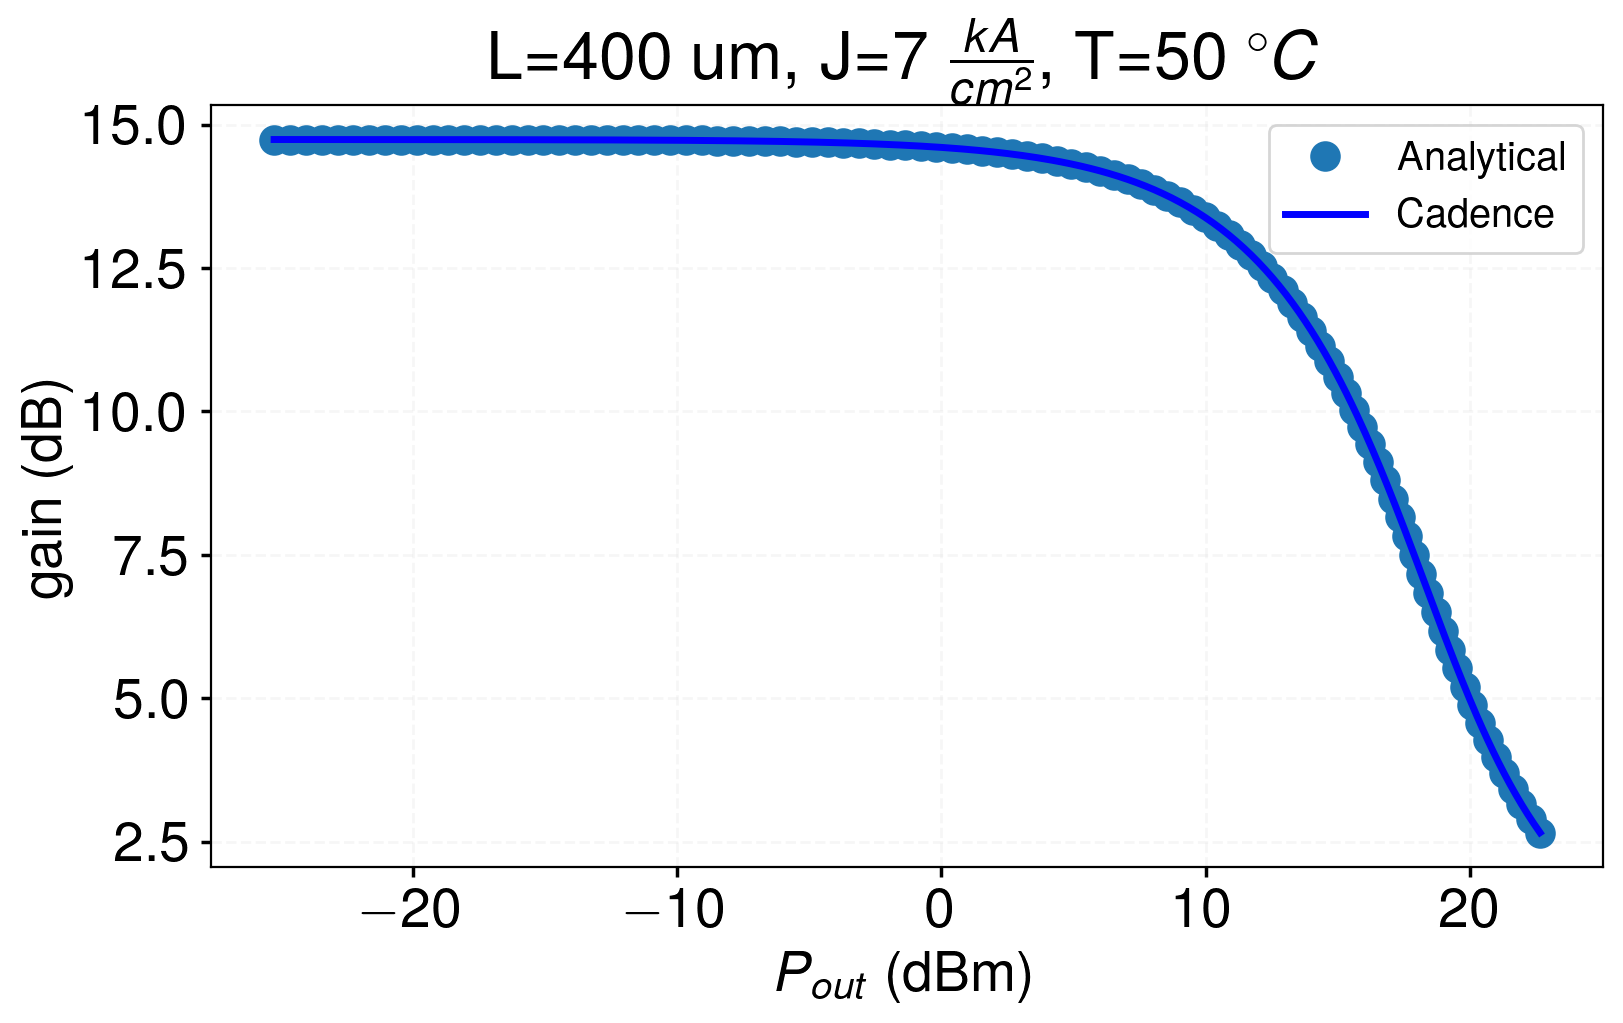

In [5]:
# Plot gain vs. input power (dBm)
# SOA parameters
T = 50
J = 7
L = 400
wav = 1310

data = pd.read_csv("Model_Data/g_dB_vs_Pin_Pout.csv").to_numpy()
Pin_cadence_dBm = data[:,1]
# Pin_cadence_dBm = 10*np.log10(Pin_cadence*1e3)
Pout_cadence_dBm = data[:,3]
# Pout_cadence_dBm = 10*np.log10(Pout_cadence*1e3)
g_dB_cadence = data[:,5]


Pin = np.linspace(-40, 20, 101)  # in dBm
Pin_Watts  = 10**(Pin/10)*1e-3
g = []
for x in Pin_Watts:
    tmp = SOA(T,J,L,wav)
    g.append(tmp.gain(x))
g = np.array(g)
g_dB = 10*np.log10(g)
# g = np.array([gain(g_unsat, x, Ps) for x in Pin])  # in dB
Pout_Watts = g * Pin_Watts  # in dBm
Pout = 10*np.log10(Pout_Watts*1e3)

z = np.polyfit(Pin, g, 3)
x = np.linspace(min(Pin), max(Pin), 1001)
y = np.polyval(z, x)

plt.figure()
plt.plot(Pin, g_dB, 'o')
# plt.plot(x, y, 'r-')
plt.plot(Pin_cadence_dBm,g_dB_cadence,"b-")
plt.ylabel(r"gain (dB)")
plt.xlabel(r"$P_{in}$ (dBm)")
plt.grid(True, which="both", ls="dashed", color='.9')
plt.legend(["Analytical","Cadence"])
plt.title(f"L={L} um, J={J} " + r"$\frac{kA}{cm^{2}}$" + f", T={T} " + r"$^{\circ} C$")
plt.show()

plt.figure()
plt.plot(Pout, g_dB, 'o')
plt.plot(Pout_cadence_dBm,g_dB_cadence,"b-")
plt.ylabel(r"gain (dB)")
plt.xlabel(r"$P_{out}$ (dBm)")
plt.grid(True, which="both", ls="dashed", color='.9')
plt.legend(["Analytical","Cadence"])
plt.title(f"L={L} um, J={J} " + r"$\frac{kA}{cm^{2}}$" + f", T={T} " + r"$^{\circ} C$")
plt.show()

In [18]:
# Plot gain and noise figure vs. J (current)
# SOA parameters
T = 50
J = np.linspace(3, 7, 101)
L = [250, 300, 350, 400]
wav = 1310

g_unsat = []
for l in L:
    g_unsat.append([g0(wav, T, j, l) for j in J])

Pos = [Pos_3dB(wav, j, T) for j in J]
nf = [noise_figure(wav, j, T) for j in J]

labels = [str(l) + " µm" for l in L]

data = pd.read_csv("Model_Data/g0_dB_vs_J.csv").to_numpy()

plt.figure()
for i in range(4):
    plt.plot(J, 10*np.log10(np.array(g_unsat)).T[:,i], label=labels[i],c=f'C{i}',linewidth=1)


plt.plot(data[:,2*0],data[:,2*0+1],c=f'C{1}',linestyle='--',linewidth=3,label='_nolegend_',zorder=100)
plt.plot(data[:,2*1],data[:,2*1+1],c=f'C{3}',linestyle='--',linewidth=3,label='_nolegend_',zorder=100)
plt.plot(data[:,2*2],data[:,2*2+1],c=f'C{0}',linestyle='--',linewidth=3,label='_nolegend_',zorder=100)
plt.plot(data[:,2*3],data[:,2*3+1],c=f'C{2}',linestyle='--',linewidth=3,label='_nolegend_',zorder=100)

plt.ylabel(r"Unsaturated gain $g_{0}$ (dB)")
plt.xlabel(r"$J$ (kA/cm$^2$)")
plt.legend(loc='upper left')
plt.grid(True, which="both", ls="dashed", color='.9')
plt.title("Unsaturated Gain vs Current Density")
plt.show()

plt.figure()
plt.plot(J, Pos, '-')
plt.ylabel(r"3dB saturated gain (dBm)")
plt.xlabel(r"$J$ (kA/cm$^2$)")
plt.grid(True, which="both", ls="dashed", color='.9')
plt.show()

plt.figure()
plt.plot(J, nf, '-')
plt.ylabel(r"Noise Figure (dB)")
plt.xlabel(r"$J$ (kA/cm$^2$)")
plt.grid(True, which="both", ls="dashed", color='.9')
plt.show()

NameError: name 'g0' is not defined

In [7]:
# Plot gain vs. input power for different SOA lengths
# SOA parameters
T = 50
J = 7
L = [250, 300, 350, 400, 440]
Pin_ranges = [(-40, 10), (-40, 10), (-40, 10), (-40, 10), (-40, 10)]
wav = 1310

Pos = Pos_3dB(wav, J, T)
nf = noise_figure(wav, J, T)

Pin_all = []
gain_all = []

for p_range, l in zip(Pin_ranges, L):
    tmp = SOA(T,J,l,wav)
    g_unsat = tmp.g0
    Ps = tmp.Psat

    Pin = np.linspace(p_range[0], p_range[1], 101)  # in dB
    Pin_Watt = 10**(Pin/10)*1e-3
    g = []
    for x in Pin_Watt:
        g.append(tmp.gain(x))
    g = np.array(g)
    g_dB = 10*np.log10(g)
    # g = np.array([gain(g_unsat, x, Ps) for x in Pin])  # in dB
    Pout_Watt = g * Pin_Watt  
    Pout = 10*np.log10(Pout_Watt * 1e3) # in dBm

    print(f"SOA length: {l} µm")
    print(f"Maximum gain: {g_unsat} dB")
    print(f"Noise figure: {nf} dB")
    print(f"3dB saturated power: {Pos} dBm")
    print(f"Saturated power: {Ps} dBm")

    Pin_all.append(Pin)
    gain_all.append(g_dB)


data = pd.read_csv("Model_Data/g_dB_vs_length.csv").to_numpy()


plt.figure()
plt.plot(np.array(Pin_all).T, np.array(gain_all).T, linewidth=1)
plt.plot(10*np.log10(data[:,2*0]*1e3),data[:,2*0+1],c=f'C{1}',linestyle='--',linewidth=3,label='_nolegend_',zorder=100)
plt.plot(10*np.log10(data[:,2*1]*1e3),data[:,2*1+1],c=f'C{3}',linestyle='--',linewidth=3,label='_nolegend_',zorder=100)
plt.plot(10*np.log10(data[:,2*2]*1e3),data[:,2*2+1],c=f'C{0}',linestyle='--',linewidth=3,label='_nolegend_',zorder=100)
plt.plot(10*np.log10(data[:,2*3]*1e3),data[:,2*3+1],c=f'C{2}',linestyle='--',linewidth=3,label='_nolegend_',zorder=100)
plt.plot(10*np.log10(data[:,2*4]*1e3),data[:,2*4+1],c=f'C{4}',linestyle='--',linewidth=3,label='_nolegend_',zorder=100)
plt.ylabel(r"Gain, g, (dB)")
plt.xlabel(r"$P_{in}$ (dBm)")
plt.grid(True, which="both", ls="dashed", color='.9')
plt.title("SOA Gain vs Length")
plt.legend(L)
plt.show()

NameError: name 'Pos_3dB' is not defined

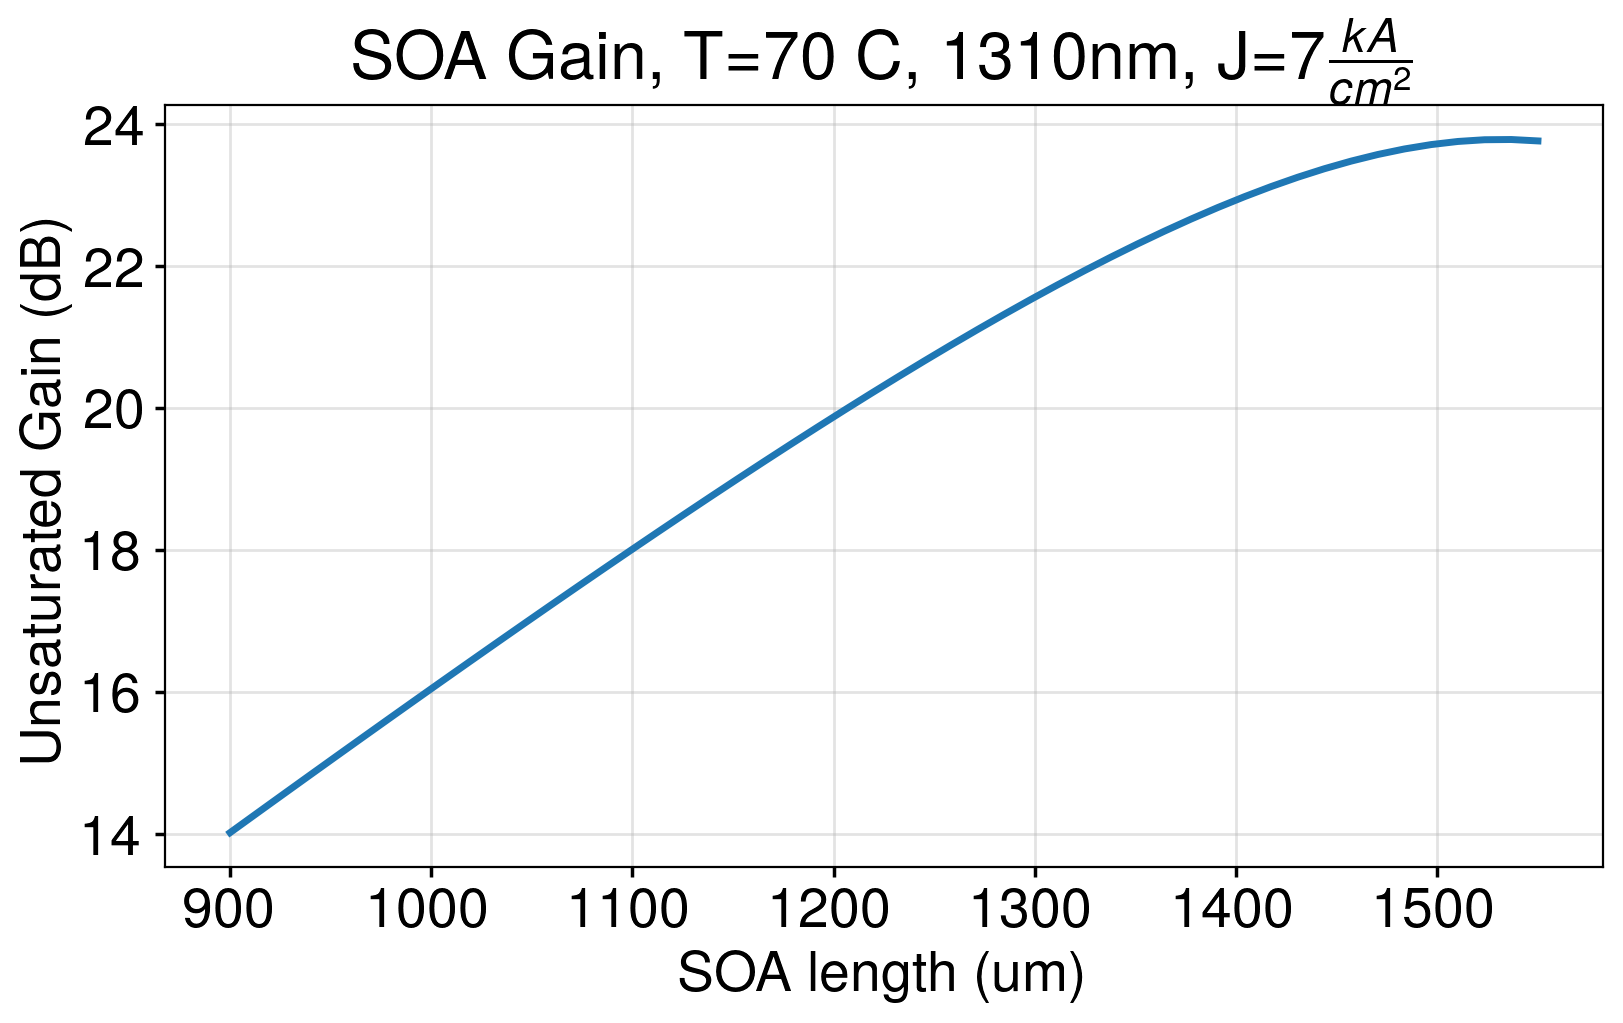

15dB length:  953.0612244897959
20dB length:  1205.1020408163265
25dB length:  1536.734693877551


In [32]:
# SOA lengths to use on Jetpack
T = 70
J = 7
Lambda = 1310
Lsweep = np.linspace(900,1550)

storage = []
for L in Lsweep:
    tmp = SOA(T,J,L-460,Lambda)
    storage.append(tmp.g0)

plt.figure()
plt.plot(Lsweep,10*np.log10(storage))
plt.xlabel("SOA length (um)")
plt.ylabel("Unsaturated Gain (dB)")
plt.title("SOA Gain, T=70 C, 1310nm, J=7" + r"$\frac{kA}{cm^{2}}$")
plt.show()

print("15dB length: ", Lsweep[np.argmin(np.abs(10*np.log10(storage) - 15))])
print("20dB length: ", Lsweep[np.argmin(np.abs(10*np.log10(storage) - 20))])
print("25dB length: ", Lsweep[np.argmin(np.abs(10*np.log10(storage) - 25))])

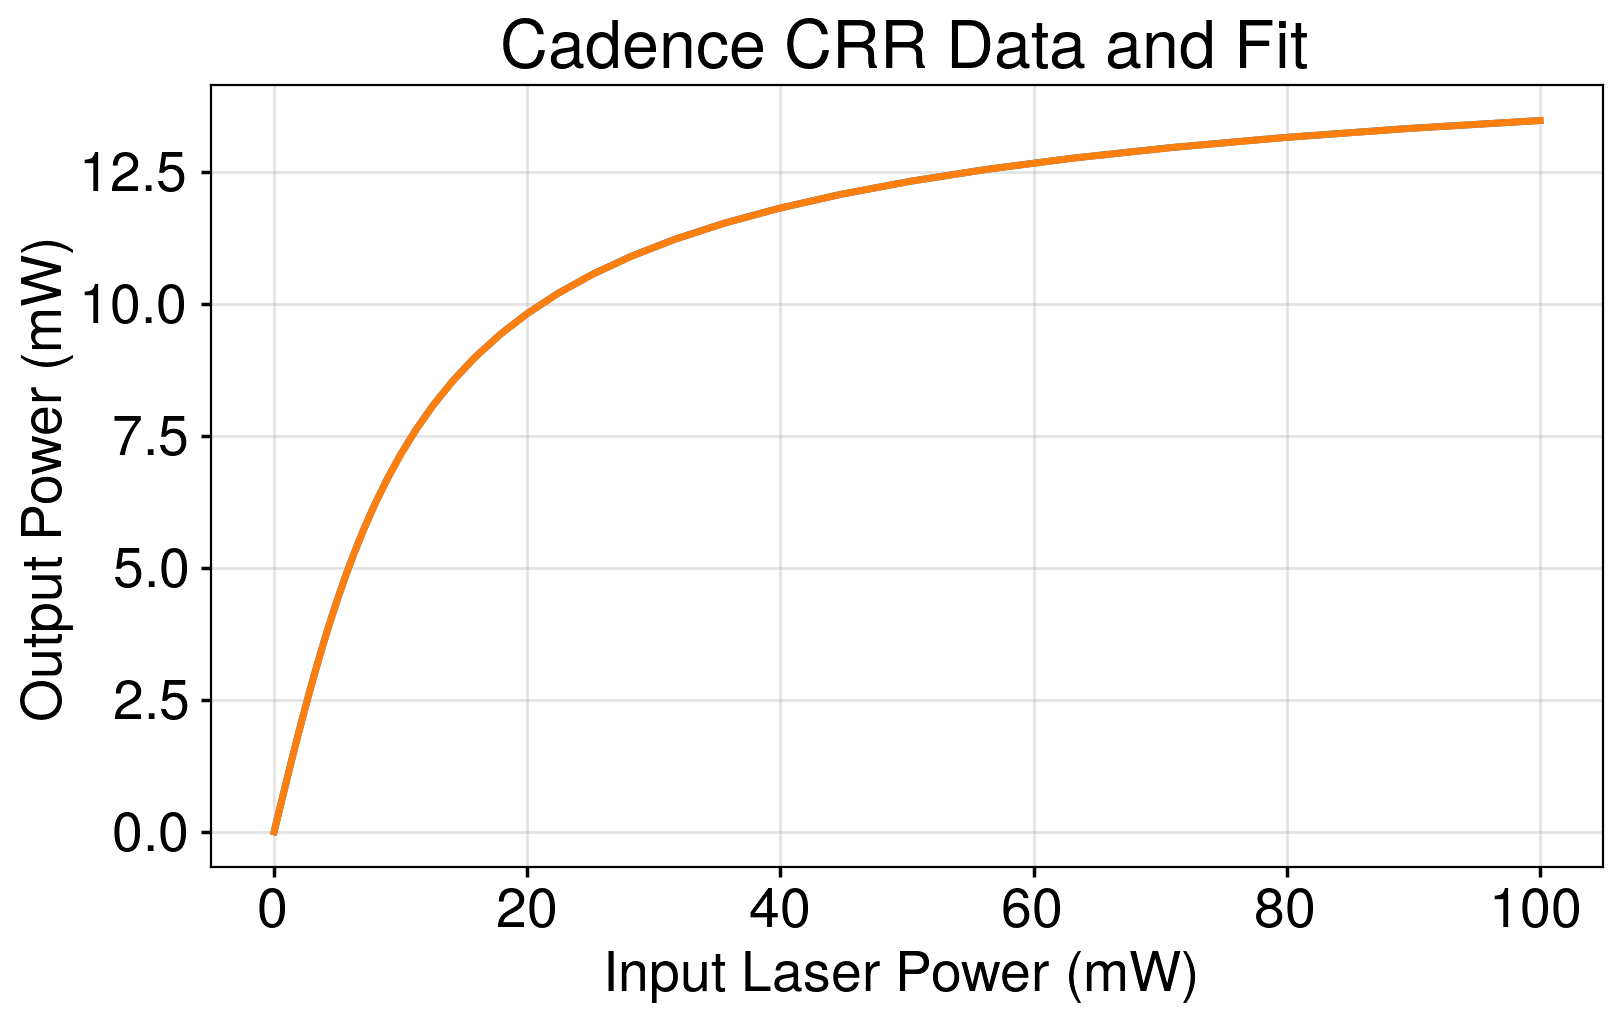

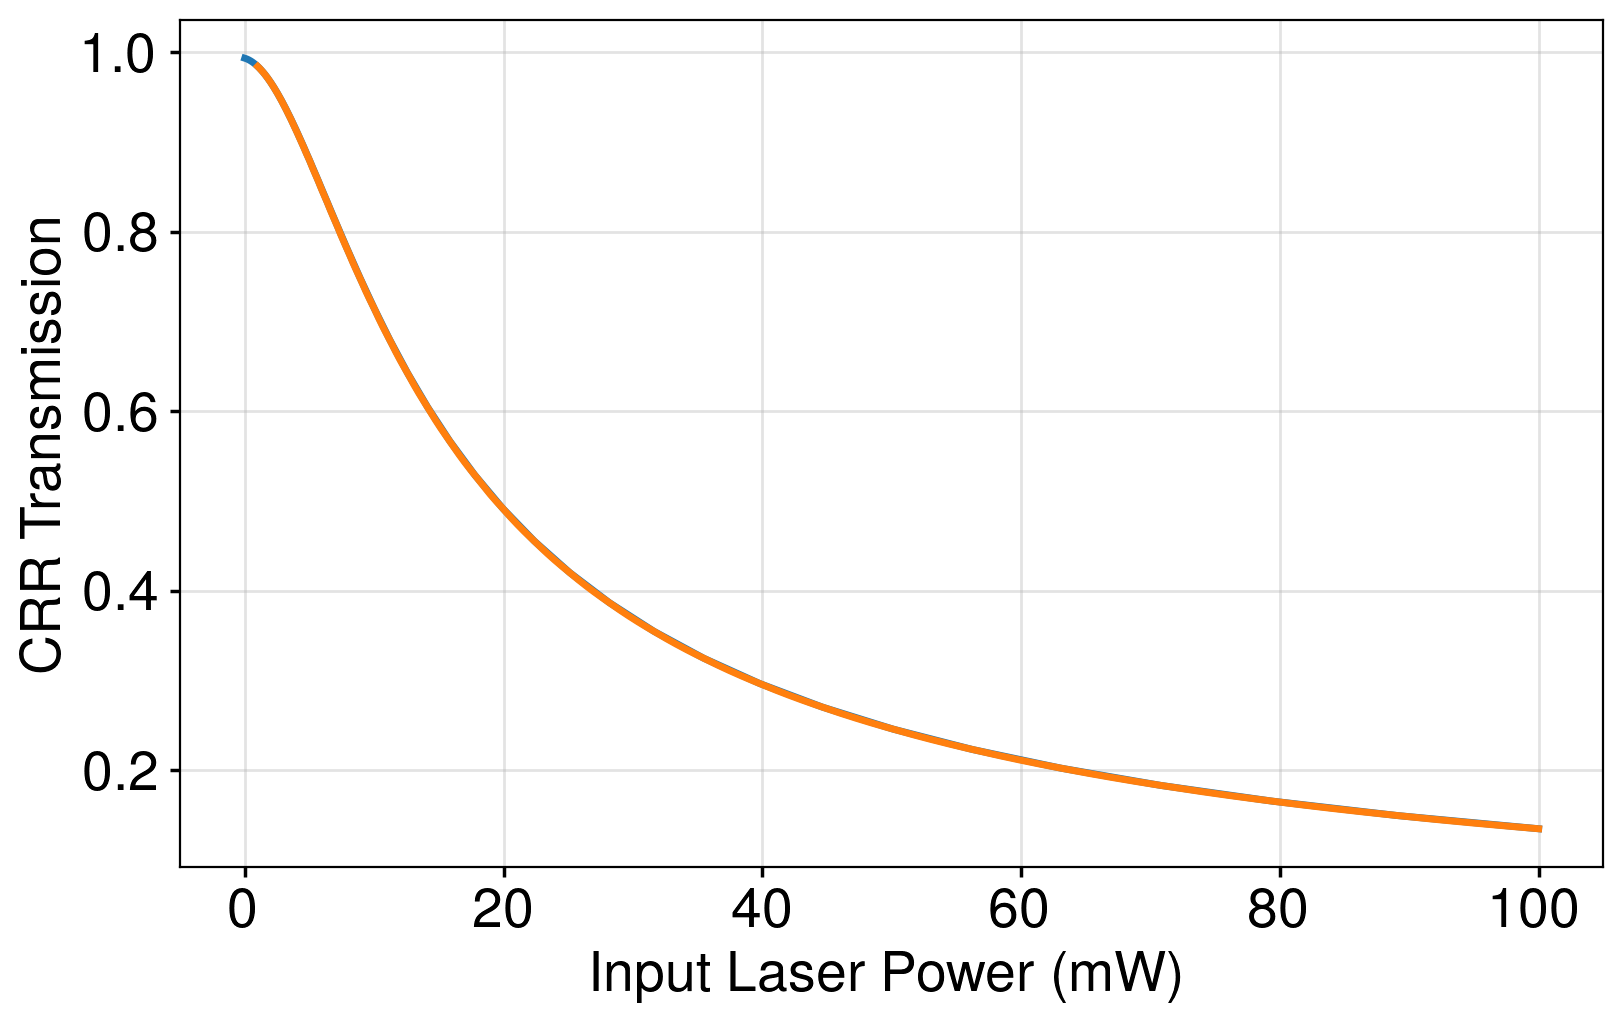

In [17]:
# CRR input-output transmission 

data = pd.read_csv("Model_Data/crr_nla_transmission.csv").to_numpy()
Pin = data[:,0]
Pout = data[:,1]

def CRR_transmission_fit(x):
    return np.clip(np.interp(x,Pin,Pout),a_min=0,a_max=1)

plt.figure()
plt.plot(Pin*1e3,Pout*1e3)
Pin_sweep = np.linspace(np.min(Pin),np.max(Pin),num=10001)
plt.plot(Pin_sweep*1e3,[CRR_transmission_fit(x)*1e3 for x in Pin_sweep])
plt.xlabel("Input Laser Power (mW)")
plt.ylabel("Output Power (mW)")
plt.title("Cadence CRR Data and Fit")
plt.show()

plt.figure()
plt.plot(Pin*1e3,Pout/Pin)
Pin_sweep = np.linspace(1e-3,np.max(Pin),num=10001)
plt.plot(Pin_sweep*1e3,[CRR_transmission_fit(x)/x for x in Pin_sweep])
plt.xlabel("Input Laser Power (mW)")
plt.ylabel("CRR Transmission")
plt.show()

def run_laser_power_sweep(Tfront=0.1,Tback=0.01,Extra_loss_dB=0,NLA=False, epsilon = 1e-8):
    Pcavity_before_SOA = 1e-6 #A seed value to get things kickstarted
    Pcavity_after_SOA = 0
    prior_Pout = 1000
    Pout = 0
    HPS_single_pass_loss_dB = 0.033
    Edge_coupler_single_pass_loss_dB = Extra_loss_dB
    HPS_transmission = 10**(-HPS_single_pass_loss_dB/10)
    EC_transmission  = 10**(-Edge_coupler_single_pass_loss_dB/10)
    soa = SOA(T=50,J=7,L=400,wl=1310)

    Pcavity_before_SOA_storage = []
    Pcavity_after_SOA_storage = []
    Pout_storage = []

    while(abs(prior_Pout - Pout) > epsilon):
        Pcavity_before_SOA_storage.append(Pcavity_before_SOA)
        g = soa.gain(Pcavity_before_SOA + Pcavity_after_SOA)
        Pcavity_after_SOA = g*Pcavity_before_SOA
        Pcavity_after_SOA_storage.append(Pcavity_after_SOA)
        Pcavity_after_SOA = Pcavity_after_SOA * HPS_transmission
        Pcavity_after_SOA = Pcavity_after_SOA * EC_transmission
        if NLA == True:
            power_for_NLA = Pcavity_after_SOA + (1-Tfront)*Pcavity_after_SOA
            CRR_transmission = CRR_transmission_fit(power_for_NLA)/(power_for_NLA) #Include effect of forward and backward wave.
            Pcavity_after_SOA = Pcavity_after_SOA * CRR_transmission
        prior_Pout = Pout
        Pout = Tfront * Pcavity_after_SOA
        Pout_storage.append(Pout)
        Pcavity_after_SOA = Pcavity_after_SOA * (1 - Tfront)
        if NLA == True:
            # power_for_NLA = Pcavity_after_SOA + Pcavity_after_SOA/ (1-Tfront)
            CRR_transmission = CRR_transmission_fit(power_for_NLA)/(power_for_NLA) #Include effect of forward and backward wave.
            Pcavity_after_SOA = Pcavity_after_SOA * CRR_transmission
        Pcavity_after_SOA = Pcavity_after_SOA * EC_transmission
        Pcavity_after_SOA = Pcavity_after_SOA * HPS_transmission
        g = soa.gain(Pcavity_before_SOA + Pcavity_after_SOA)
        Pcavity_before_SOA = g*Pcavity_after_SOA
        Pcavity_before_SOA = Pcavity_before_SOA* (1 - Tback)
    return Pout



loss: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


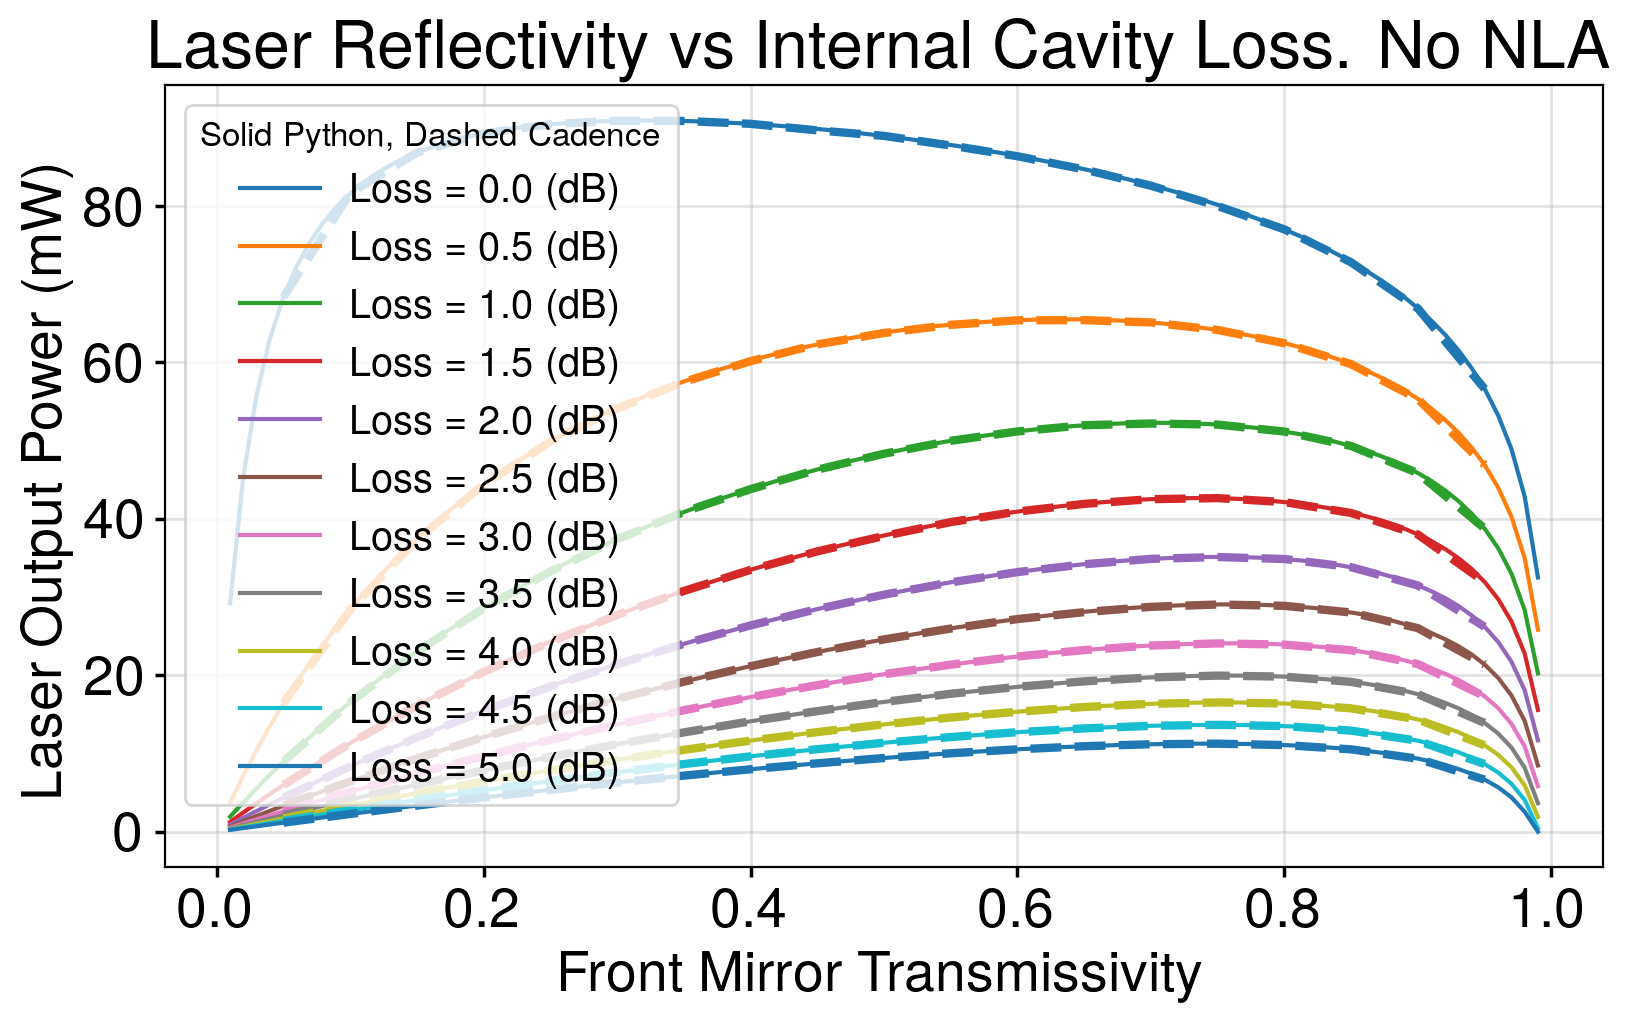

In [9]:
############ WITHOUT NLA ################
Loss_sweep_dB = np.linspace(0,5,num=11)
Tfront_sweep = np.linspace(0.01,0.99,num=100)
loss_storage=  []

for extra_loss_dB in tqdm(Loss_sweep_dB,desc='loss'):
    Pout_storage = []
    for Tfront in Tfront_sweep:
        Pout_storage.append(run_laser_power_sweep(Tfront=Tfront,Extra_loss_dB=extra_loss_dB,NLA=False))
    Pout_storage = np.array(Pout_storage)
    loss_storage.append(Pout_storage)
loss_storage = np.array(loss_storage)

data = pd.read_csv("Model_Data/SOA_with_tunable_reflectors_Tfront_extra_loss_sweep.csv").to_numpy()

T_sweep_cadence = np.linspace(0.05,0.95,num=19)

plt.figure()
for i in range(loss_storage.shape[0]):
    label = "Loss = " + str(Loss_sweep_dB[i]) + " (dB)"
    plt.plot(Tfront_sweep,loss_storage.T[:,i]*1e3,c=f'C{i}',linestyle='-',linewidth=1.5,label=label)
for i in range(data.shape[1]//2):
    label = '_nolegend_'
    plt.plot(T_sweep_cadence,data[:,2*i+1]*1e3,c=f'C{i}',linestyle='--',linewidth=3,label=label)
plt.xlabel("Front Mirror Transmissivity")
plt.ylabel("Laser Output Power (mW)")
plt.title("Laser Reflectivity vs Internal Cavity Loss. No NLA")
plt.legend(title='Solid Python, Dashed Cadence',title_fontsize=12)
plt.show()

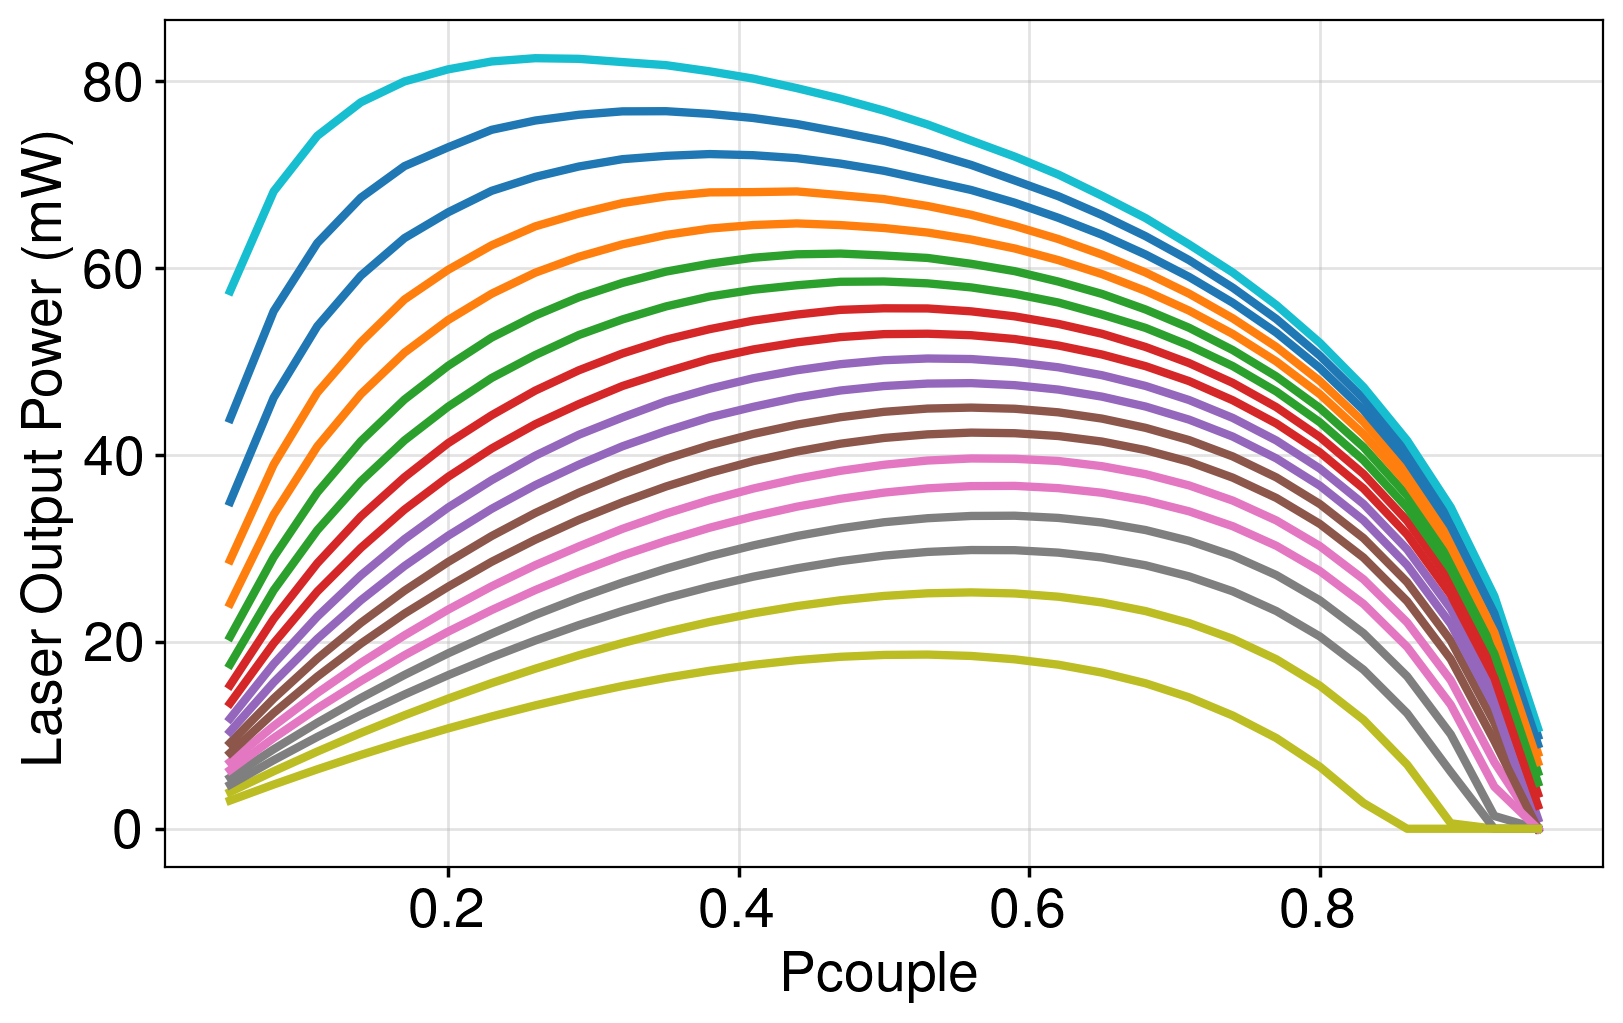

Text(0, 0.5, 'Output Power (mW)')

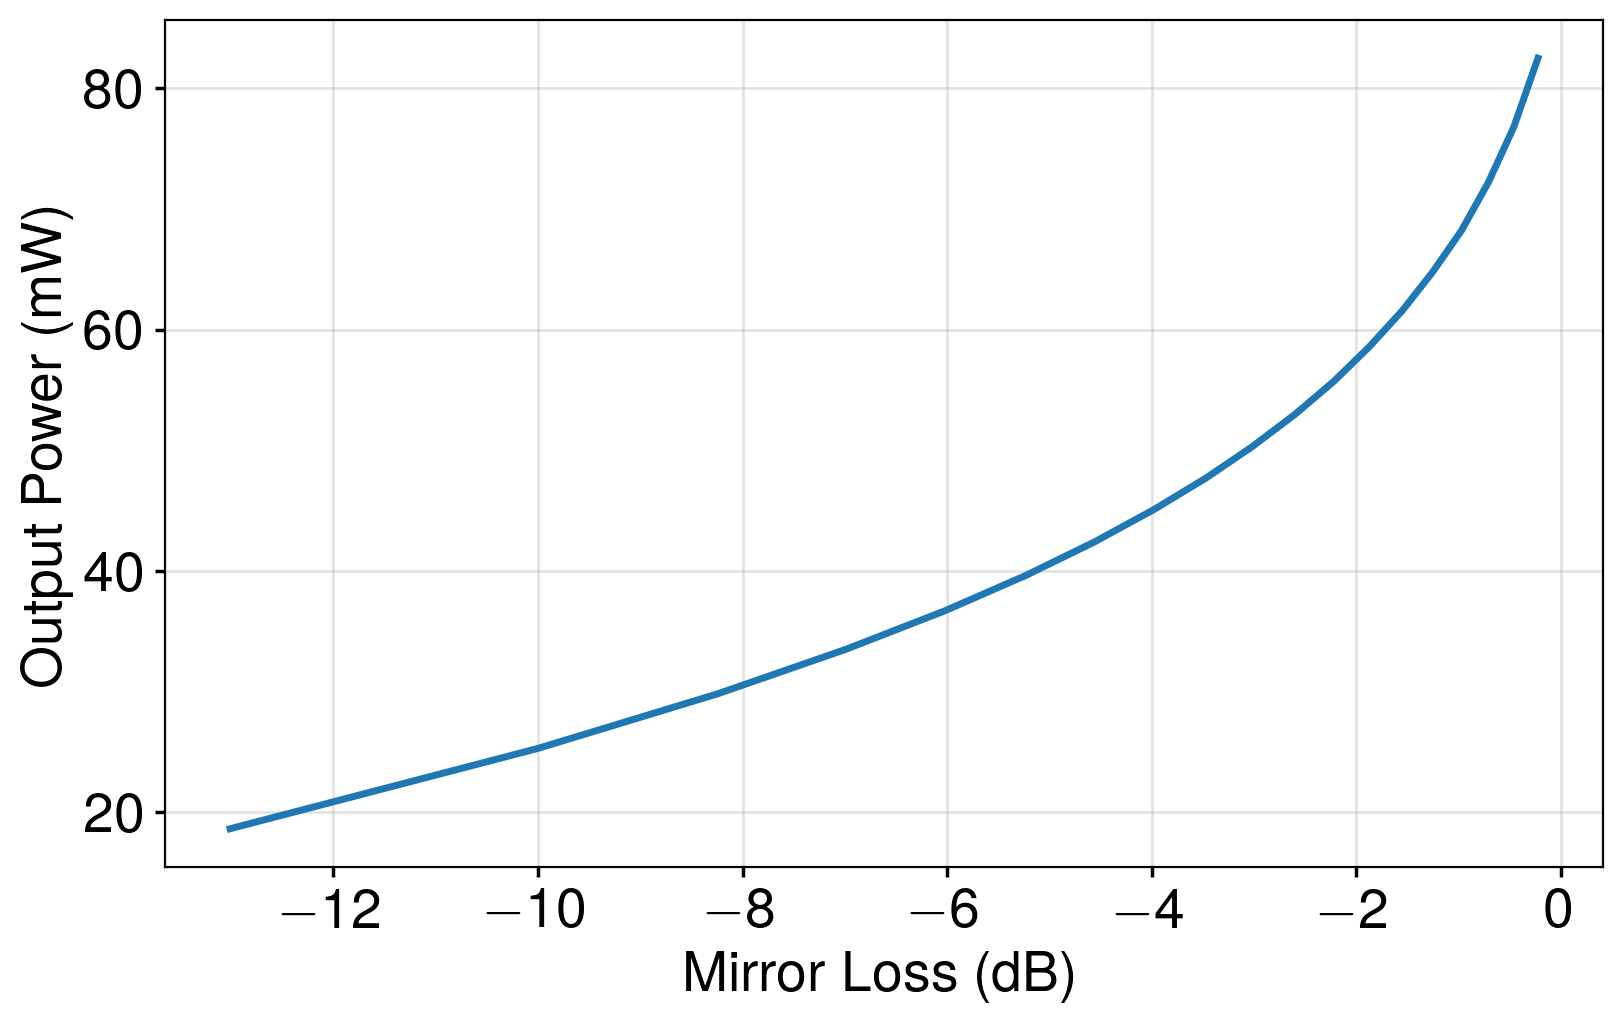

In [10]:
############ Sweep Pcouple and Tfront ################

data = pd.read_csv("Model_Data/Pout_vs_Tfront_Pcouple.csv").to_numpy()

T_sweep_cadence = np.linspace(0.05,0.95,num=31)
mirror_loss_dB = 10*np.log10(1-np.linspace(0.05,0.95,num=19))
best_power = []

plt.figure()
for i in range(data.shape[1]//2):
    label = '_nolegend_'
    plt.plot(T_sweep_cadence,data[:,2*i+1]*1e3,linestyle='-',linewidth=3,label=label)
    best_power.append(np.max(data[:,2*i+1]))
plt.xlabel("Pcouple")
plt.ylabel("Laser Output Power (mW)")
plt.show()

best_power = np.array(best_power)
best_power = best_power[np.argsort(best_power)[::-1]]
plt.figure()
plt.plot(mirror_loss_dB,best_power*1e3)
plt.xlabel("Mirror Loss (dB)")
plt.ylabel("Output Power (mW)")


loss: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


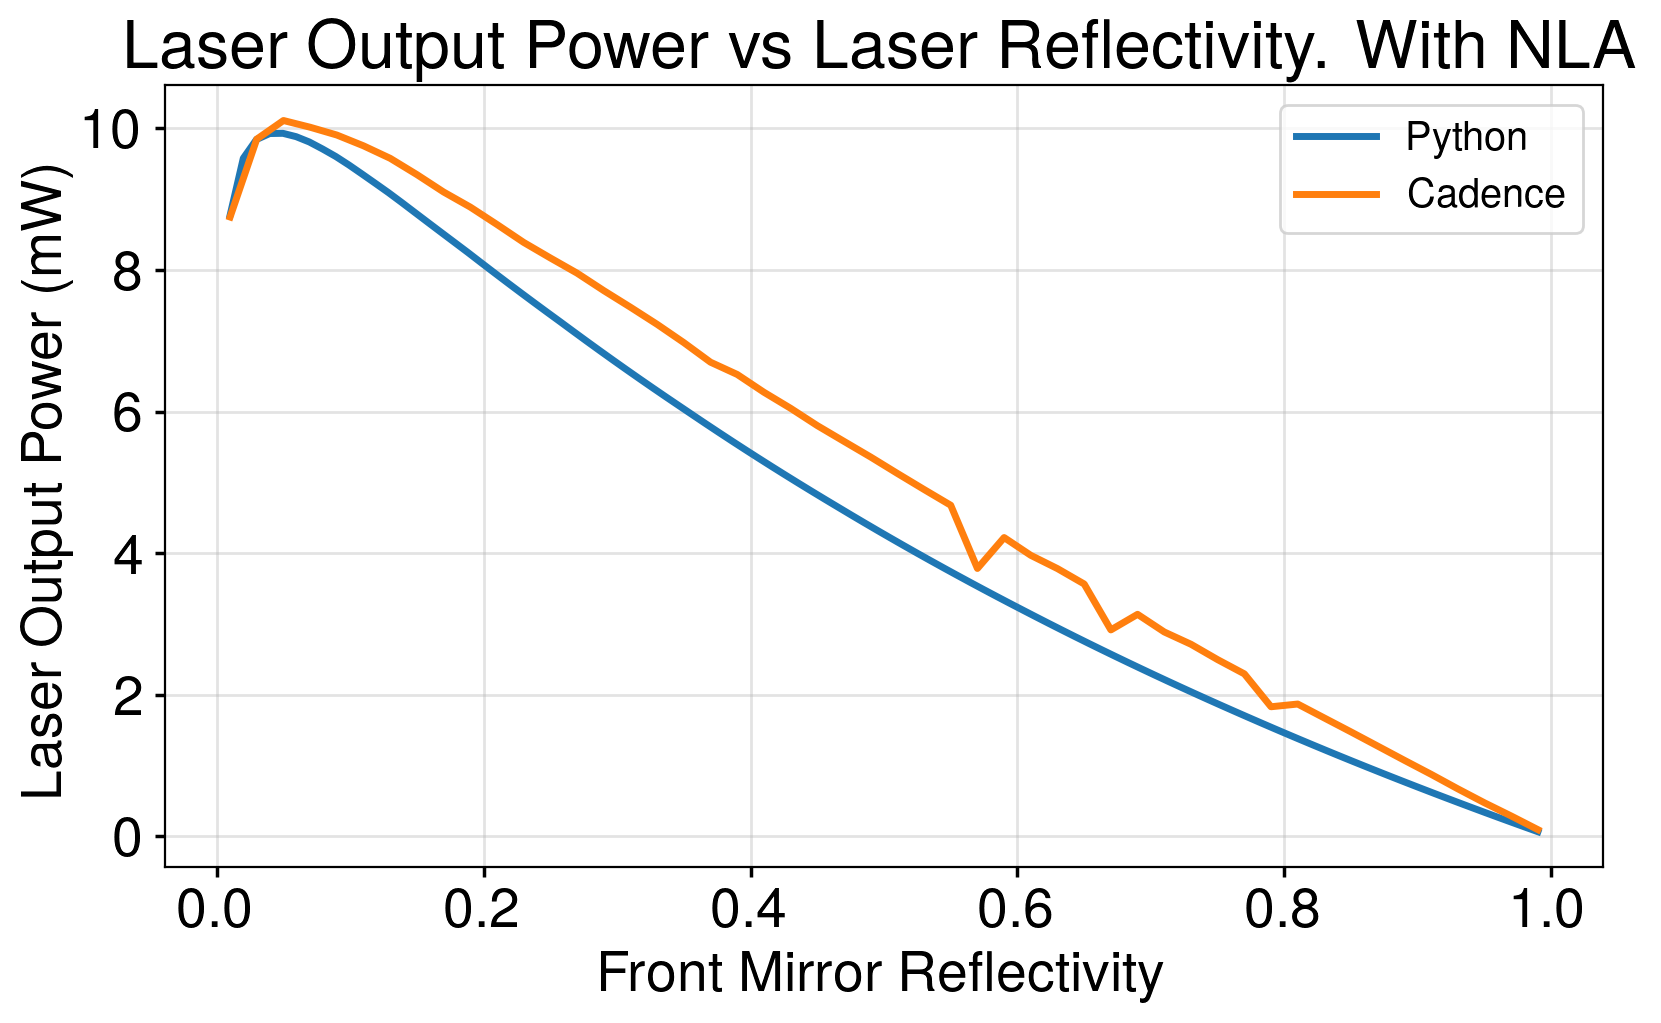

In [11]:
############ WITH NLA ################
cadence_data = pd.read_csv("Model_Data/partial_vernier_laser_output_power.csv").to_numpy()

Loss_sweep_dB = [0]
loss_storage=  []
for extra_loss_dB in tqdm(Loss_sweep_dB,desc='loss'):
    Pout_storage = []
    for Tfront in Tfront_sweep:
        Pout_storage.append(run_laser_power_sweep(Tfront=Tfront,Extra_loss_dB=extra_loss_dB,NLA=True))
    Pout_storage = np.array(Pout_storage)
    loss_storage.append(Pout_storage)
loss_storage = np.array(loss_storage)

plt.figure()
plt.plot(1 - Tfront_sweep,loss_storage.T*1e3)
plt.plot(1 - cadence_data[:,0],cadence_data[:,1]*1e3)
plt.xlabel("Front Mirror Reflectivity")
plt.ylabel("Laser Output Power (mW)")
plt.title("Laser Output Power vs Laser Reflectivity. With NLA")
plt.legend(
    ["Python","Cadence"]
)
plt.show()

[4.04732793e-02 3.81499317e-02 3.60119653e-02 3.40374310e-02
 3.22078013e-02 3.05073296e-02 2.89225474e-02 2.74418671e-02
 2.60552643e-02 2.47540226e-02 2.35305262e-02 2.23780912e-02
 2.12908260e-02 2.02635168e-02 1.92915314e-02 1.83707394e-02
 1.74974448e-02 1.66683293e-02 1.58804040e-02 1.51309681e-02
 1.44175741e-02 1.37379972e-02 1.30902096e-02 1.24723578e-02
 1.18827432e-02 1.13198051e-02 1.07821060e-02 1.02683183e-02
 9.77721336e-03 9.30765136e-03 8.85857245e-03 8.42898906e-03
 8.01797902e-03 7.62467952e-03 7.24828165e-03 6.88802563e-03
 6.54319653e-03 6.21312048e-03 5.89716120e-03 5.59471699e-03
 5.30521799e-03 5.02812372e-03 4.76292083e-03 4.50912117e-03
 4.26625997e-03 4.03389420e-03 3.81160114e-03 3.59897701e-03
 3.39563578e-03 3.20120811e-03 3.01534030e-03 2.83769338e-03
 2.66794232e-03 2.50577524e-03 2.35089271e-03 2.20300713e-03
 2.06184210e-03 1.92713191e-03 1.79862101e-03 1.67606357e-03
 1.55922303e-03 1.44787167e-03 1.34179028e-03 1.24076777e-03
 1.14460087e-03 1.053093

Text(0.5, 1.0, 'Laser Output Power vs Attenuation')

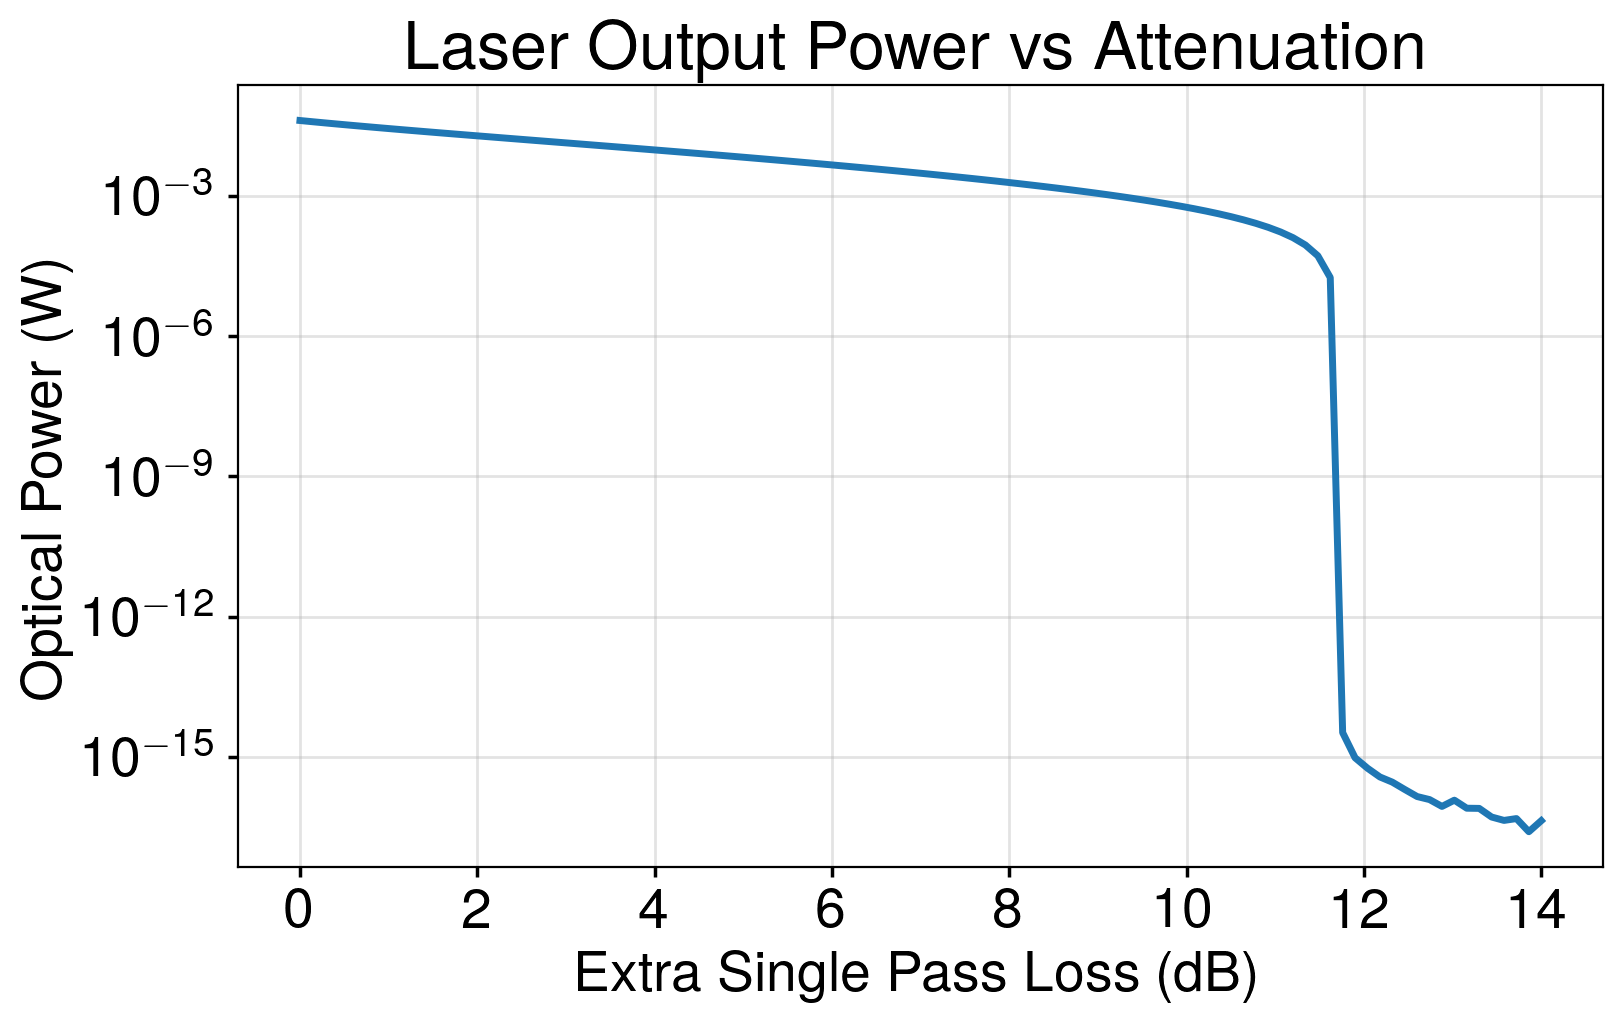

In [12]:
# What makes this a laser? There should exist some loss such that no amount of transmission will allow lasing
Loss_sweep_dB = np.linspace(0,14,num=101)
output_power = np.array([run_laser_power_sweep(Tfront=0.5,Tback=0.5,Extra_loss_dB=i,NLA=False,epsilon=1e-16) for i in Loss_sweep_dB])
print(output_power)
plt.figure()
plt.semilogy(Loss_sweep_dB,output_power)
plt.ylabel("Optical Power (W)")
plt.xlabel("Extra Single Pass Loss (dB)")
plt.title("Laser Output Power vs Attenuation")

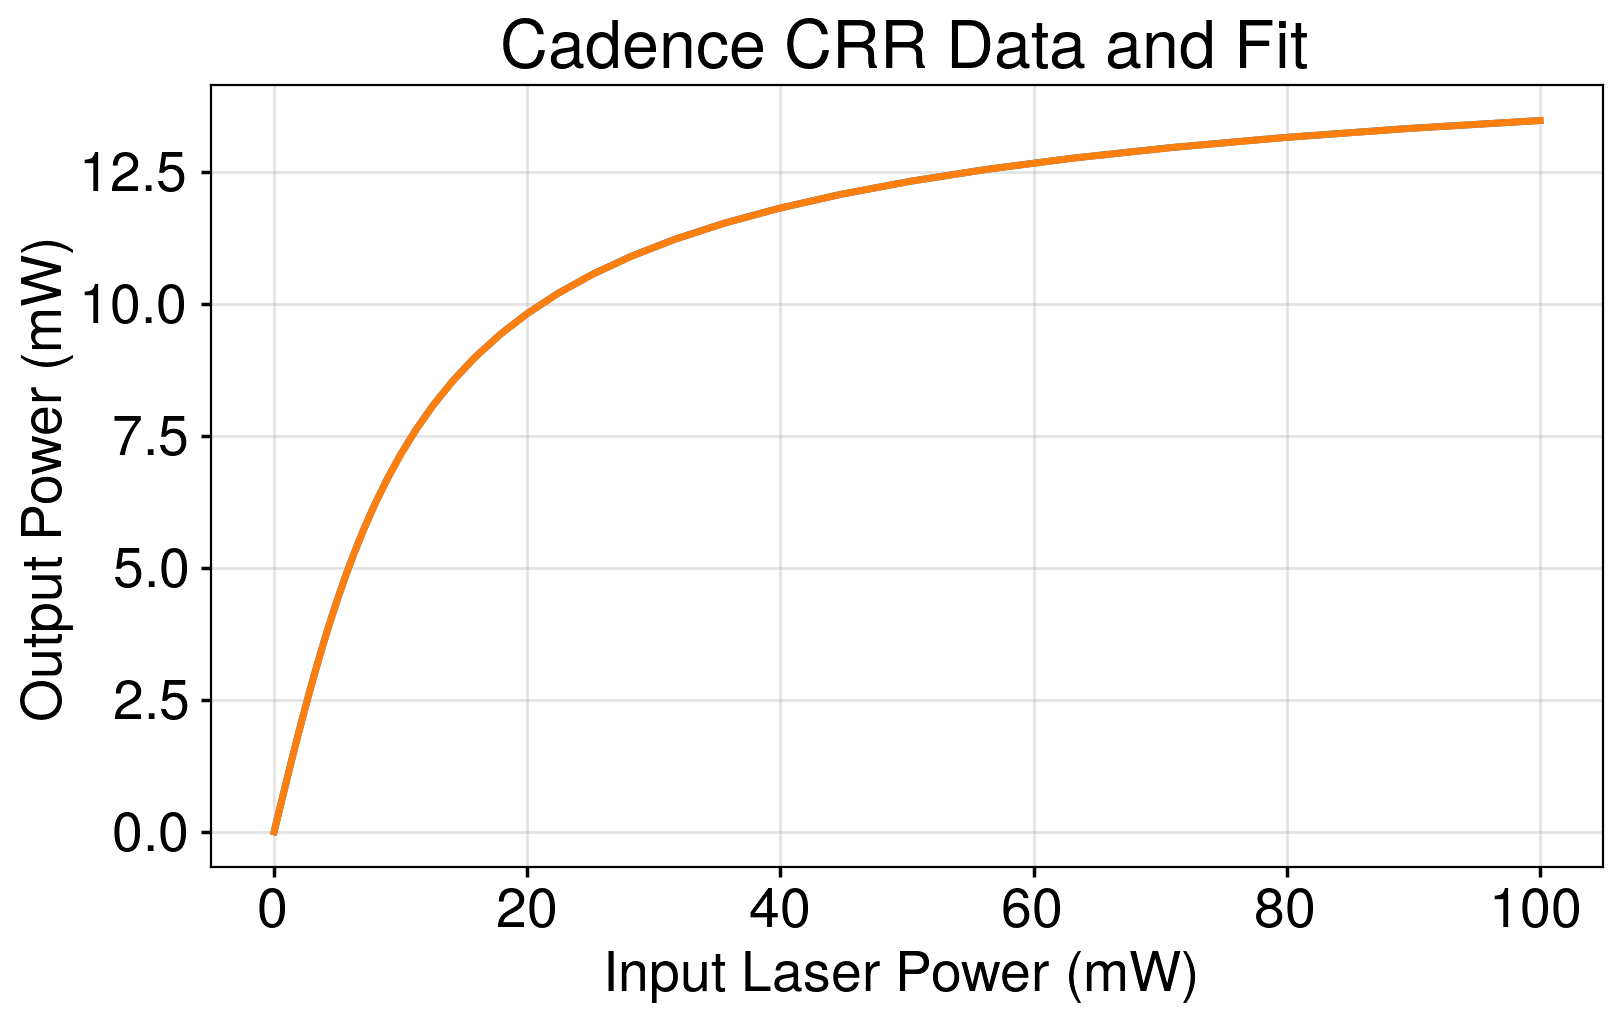

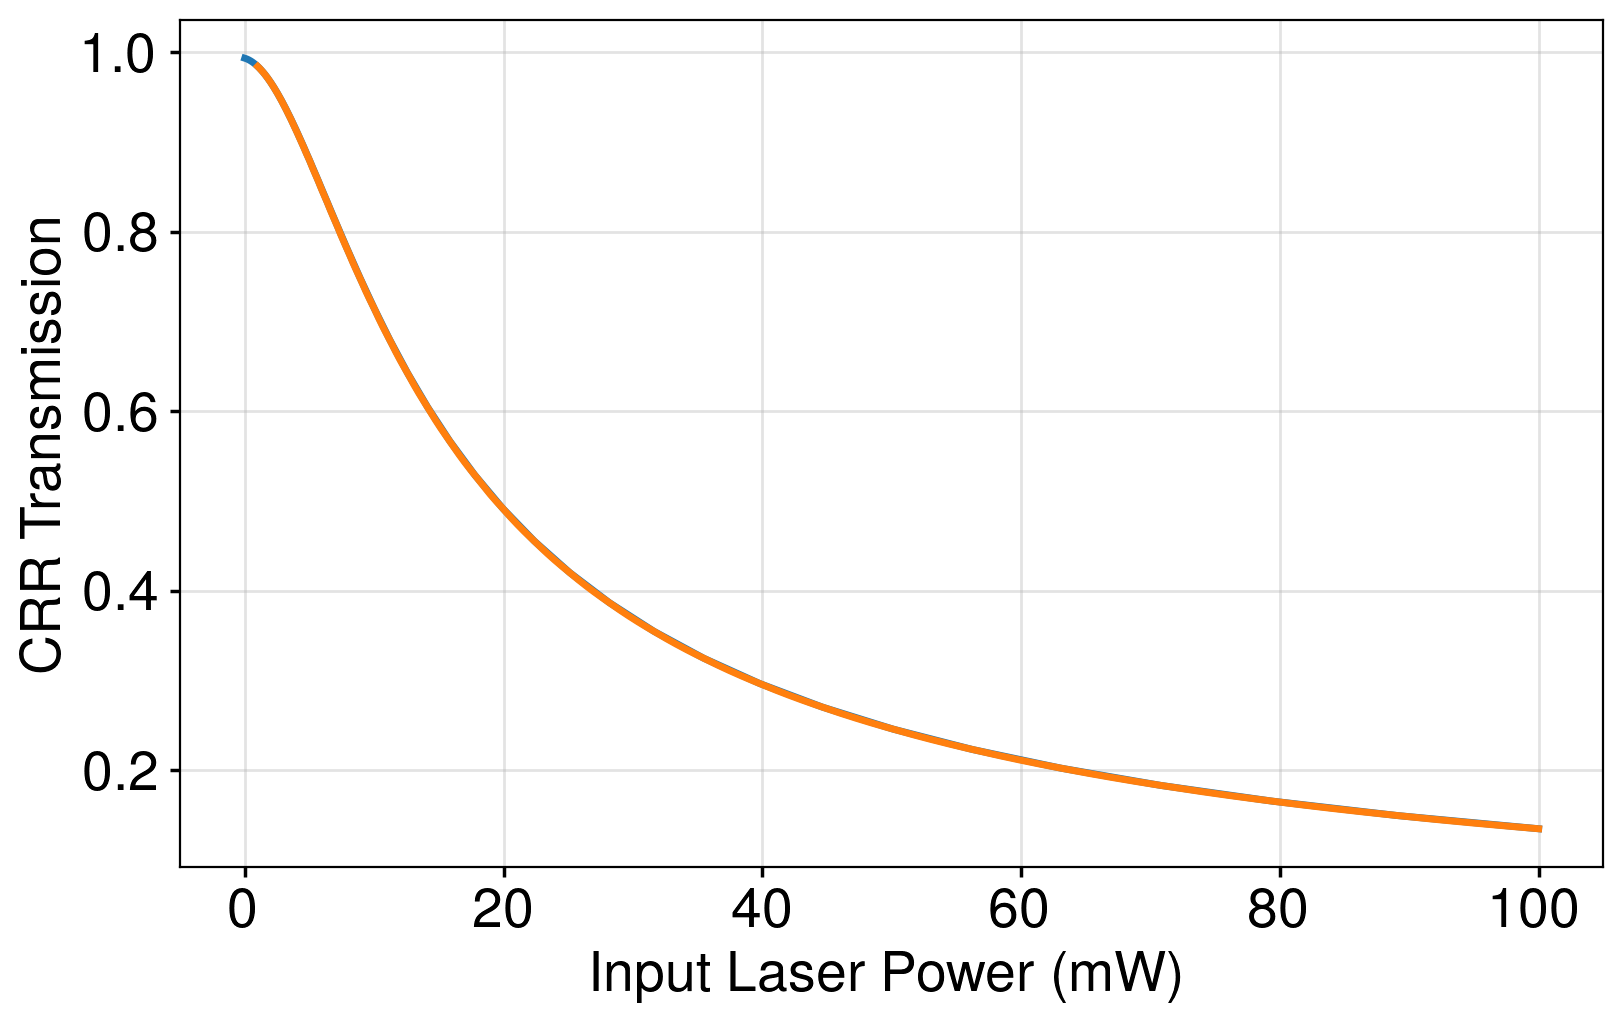

In [13]:
# Get an estimate of SiN Ring + XPS laser performance
# CRR input-output transmission 

data = pd.read_csv("Model_Data/crr_nla_transmission.csv").to_numpy()
Pin = data[:,0]
Pout = data[:,1]

def CRR_transmission_fit(x):
    return np.clip(np.interp(x,Pin,Pout),a_min=0,a_max=1)

plt.figure()
plt.plot(Pin*1e3,Pout*1e3)
Pin_sweep = np.linspace(np.min(Pin),np.max(Pin),num=10001)
plt.plot(Pin_sweep*1e3,[CRR_transmission_fit(x)*1e3 for x in Pin_sweep])
plt.xlabel("Input Laser Power (mW)")
plt.ylabel("Output Power (mW)")
plt.title("Cadence CRR Data and Fit")
plt.show()

plt.figure()
plt.plot(Pin*1e3,Pout/Pin)
Pin_sweep = np.linspace(1e-3,np.max(Pin),num=10001)
plt.plot(Pin_sweep*1e3,[CRR_transmission_fit(x)/x for x in Pin_sweep])
plt.xlabel("Input Laser Power (mW)")
plt.ylabel("CRR Transmission")
plt.show()

def run_SiN_XPS_laser_power_sweep(Tfront=0.1,Tback=0.01,Extra_loss_dB=0,NLA=False, epsilon = 1e-8):
    Pcavity_before_SOA = 1e-6 #A seed value to get things kickstarted
    Pcavity_after_SOA = 0
    prior_Pout = 1000
    Pout = 0
    HPS_single_pass_loss_dB = 0.033
    Edge_coupler_single_pass_loss_dB = Extra_loss_dB
    HPS_transmission = 10**(-HPS_single_pass_loss_dB/10)
    EC_transmission  = 10**(-Edge_coupler_single_pass_loss_dB/10)
    soa = SOA(T=50,J=7,L=400,wl=1310)

    Pcavity_before_SOA_storage = []
    Pcavity_after_SOA_storage = []
    Pout_storage = []

    while(abs(prior_Pout - Pout) > epsilon):
        Pcavity_before_SOA_storage.append(Pcavity_before_SOA)
        g = soa.gain(Pcavity_before_SOA + Pcavity_after_SOA)
        Pcavity_after_SOA = g*Pcavity_before_SOA
        Pcavity_after_SOA_storage.append(Pcavity_after_SOA)
        Pcavity_after_SOA = Pcavity_after_SOA * HPS_transmission
        Pcavity_after_SOA = Pcavity_after_SOA * EC_transmission
        if NLA == True:
            power_for_NLA = Pcavity_after_SOA + (1-Tfront)*Pcavity_after_SOA
            CRR_transmission = CRR_transmission_fit(power_for_NLA)/(power_for_NLA) #Include effect of forward and backward wave.
            Pcavity_after_SOA = Pcavity_after_SOA * CRR_transmission
        prior_Pout = Pout
        Pout = Tfront * Pcavity_after_SOA
        Pout_storage.append(Pout)
        Pcavity_after_SOA = Pcavity_after_SOA * (1 - Tfront)
        if NLA == True:
            # power_for_NLA = Pcavity_after_SOA + Pcavity_after_SOA/ (1-Tfront)
            CRR_transmission = CRR_transmission_fit(power_for_NLA)/(power_for_NLA) #Include effect of forward and backward wave.
            Pcavity_after_SOA = Pcavity_after_SOA * CRR_transmission
        Pcavity_after_SOA = Pcavity_after_SOA * EC_transmission
        Pcavity_after_SOA = Pcavity_after_SOA * HPS_transmission
        g = soa.gain(Pcavity_before_SOA + Pcavity_after_SOA)
        Pcavity_before_SOA = g*Pcavity_after_SOA
        Pcavity_before_SOA = Pcavity_before_SOA* (1 - Tback)
    return Pout



/var/folders/cz/sbzsny857hz32jgc2dxnldjm0000gn/T/ipykernel_8582/828276334.py:18: RuntimeWarning: invalid value encountered in divide
  efficiency = power_storage/power_1_8V_storage


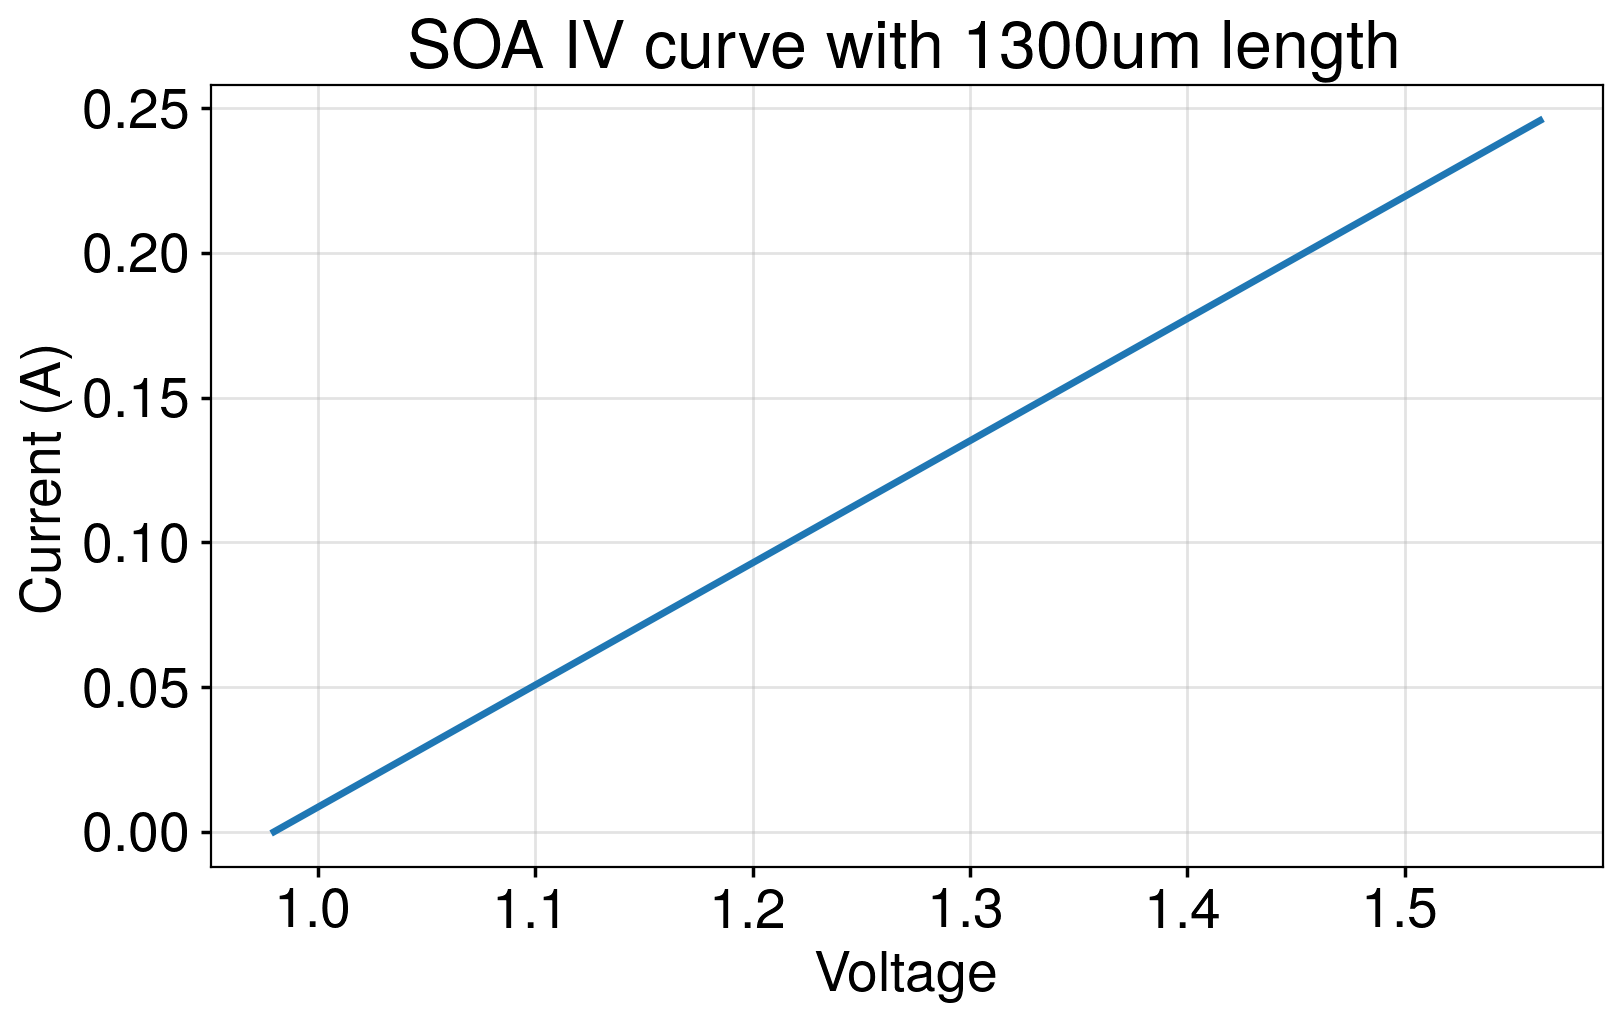

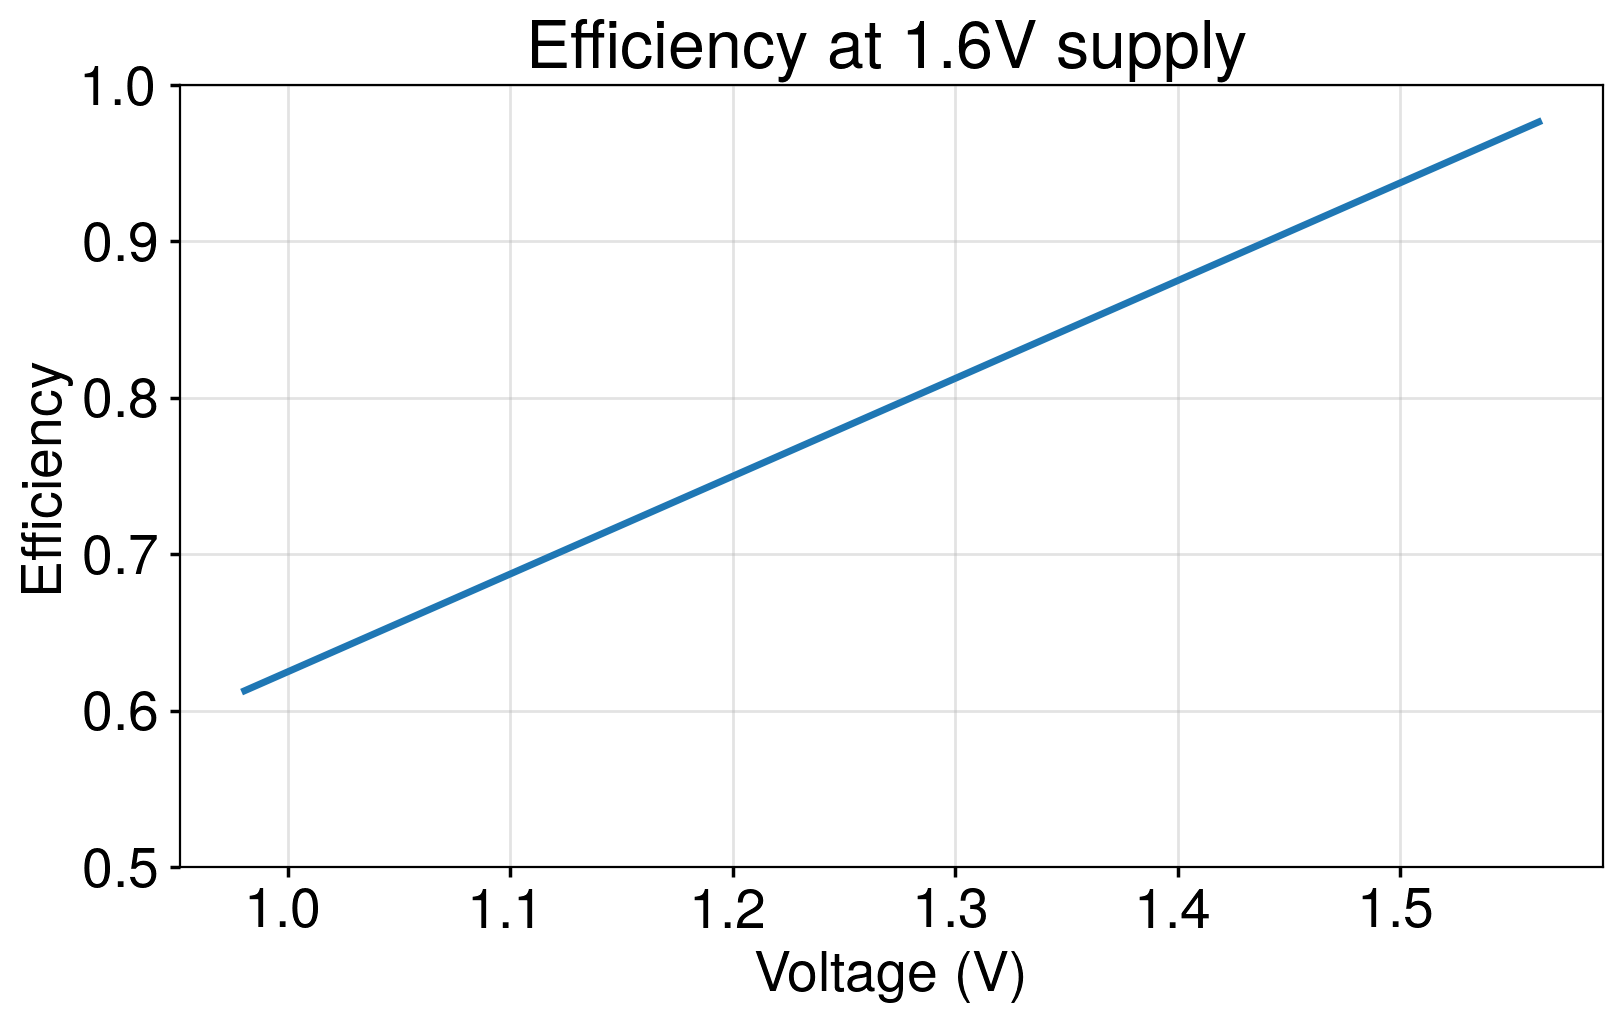

In [14]:
# SOA IV curves
Lsoa = 1300 * 1e-6
W = 2.7e-6
current_storage = []
voltage_storage = []
J_sweep = np.linspace(0,7,num=1000)
for J in J_sweep:
    I = J * 1e7 * W * Lsoa
    current_storage.append(I)
    V = 0.98 + 2.8 * I * (1100*1e-6/Lsoa)
    voltage_storage.append(V)

current_storage = np.array(current_storage)
voltage_storage = np.array(voltage_storage)

power_storage = np.multiply(current_storage, voltage_storage)
power_1_8V_storage = 1.6 * current_storage
efficiency = power_storage/power_1_8V_storage

plt.figure()
plt.plot(voltage_storage,current_storage)
plt.xlabel("Voltage")
plt.ylabel("Current (A)")
plt.title("SOA IV curve with 1300um length")
plt.show()

plt.figure()
plt.plot(voltage_storage,efficiency)
plt.xlabel("Voltage (V)")
plt.ylabel("Efficiency")
plt.title("Efficiency at 1.6V supply")
plt.yticks(ticks=[0.5,0.6,0.7,0.8,0.9,1.0])
plt.show()

T = 35, lambda_peak = 1288.2481914241991 (nm), FWHM = 57.11191064632517 (nm), gpeak = 18.321813561644028 (dB)
T = 55, lambda_peak = 1296.196327904518 (nm), FWHM = 60.474969819500934 (nm), gpeak = 16.120773701847963 (dB)
T = 70, lambda_peak = 1304.5411402647574 (nm), FWHM = 65.22738019938278 (nm), gpeak = 14.145963807000918 (dB)
T = 80, lambda_peak = 1311.2394485049174 (nm), FWHM = 69.45761378597068 (nm), gpeak = 12.675123877102891 (dB)
T = 35, left channel required Vernier FSR (nm): 55.764948984491184
T = 35, right channel required Vernier FSR (nm): 72.07661932917154
T = 55, left channel required Vernier FSR (nm): 43.08041207710971
T = 55, right channel required Vernier FSR (nm): 57.18164033337234
T = 70, left channel required Vernier FSR (nm): 34.13662331935825
T = 70, right channel required Vernier FSR (nm): 44.73515103551267
T = 80, left channel required Vernier FSR (nm): 40.74635327596093
T = 80, right channel required Vernier FSR (nm): 37.72974995529671


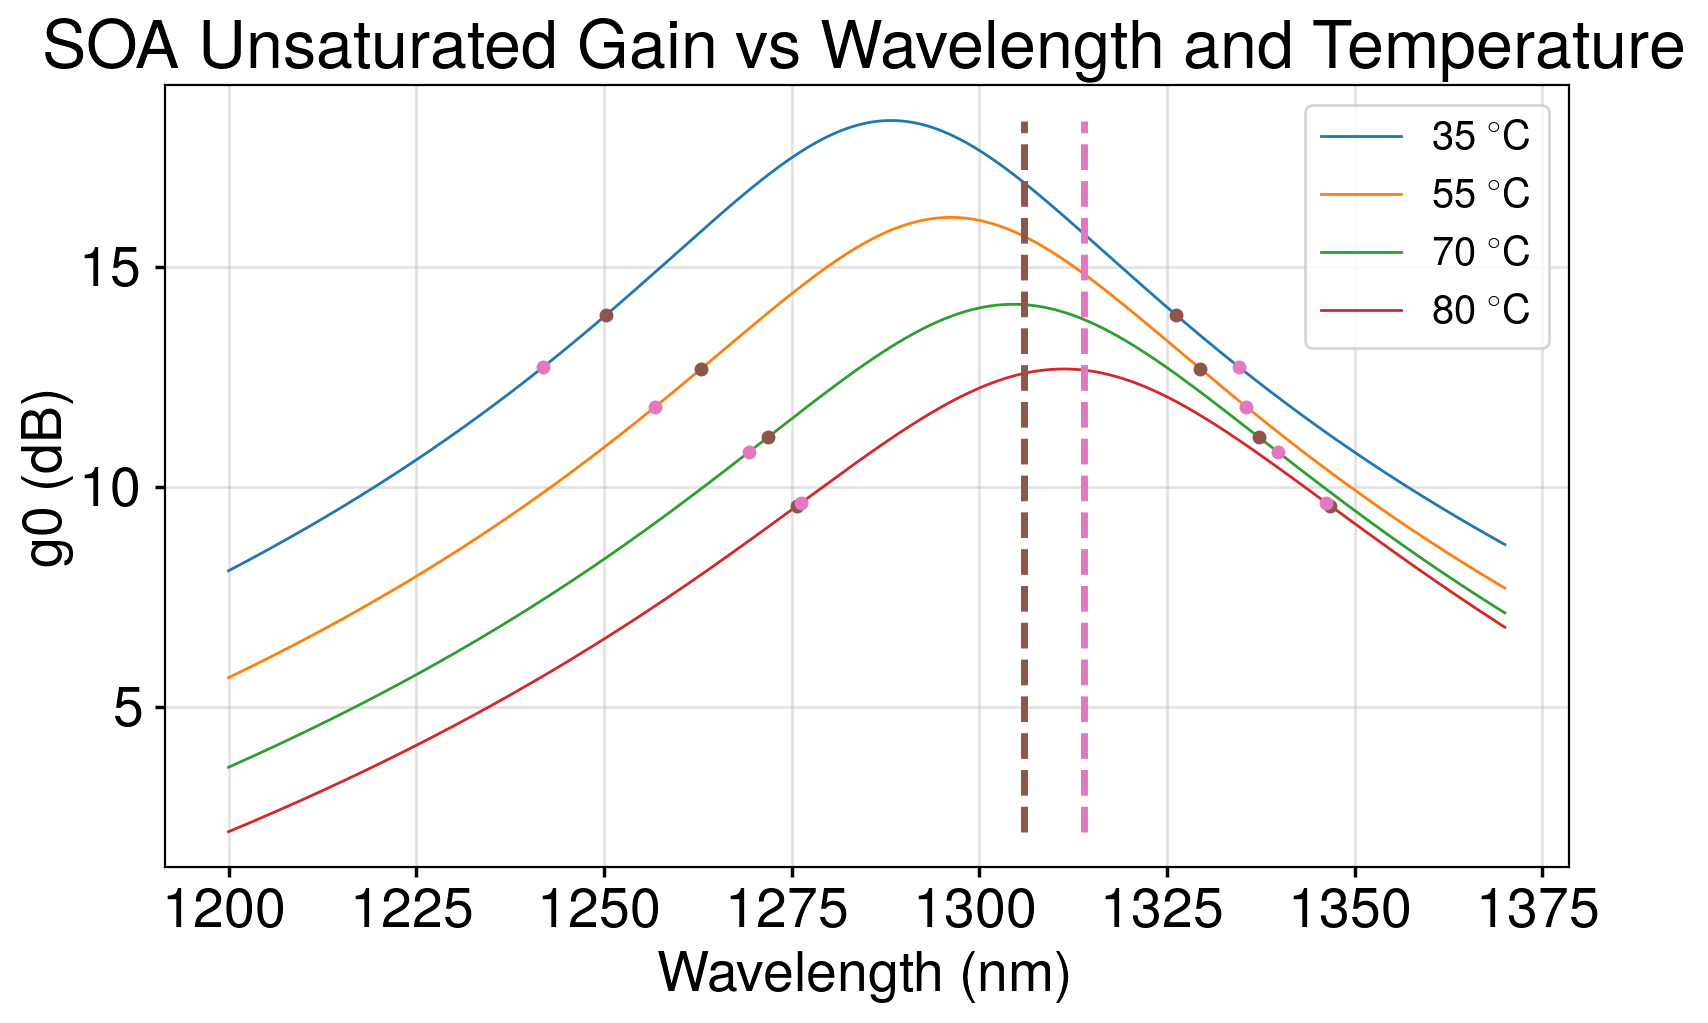

temperature sweep: 100%|██████████| 100/100 [00:08<00:00, 11.23it/s]


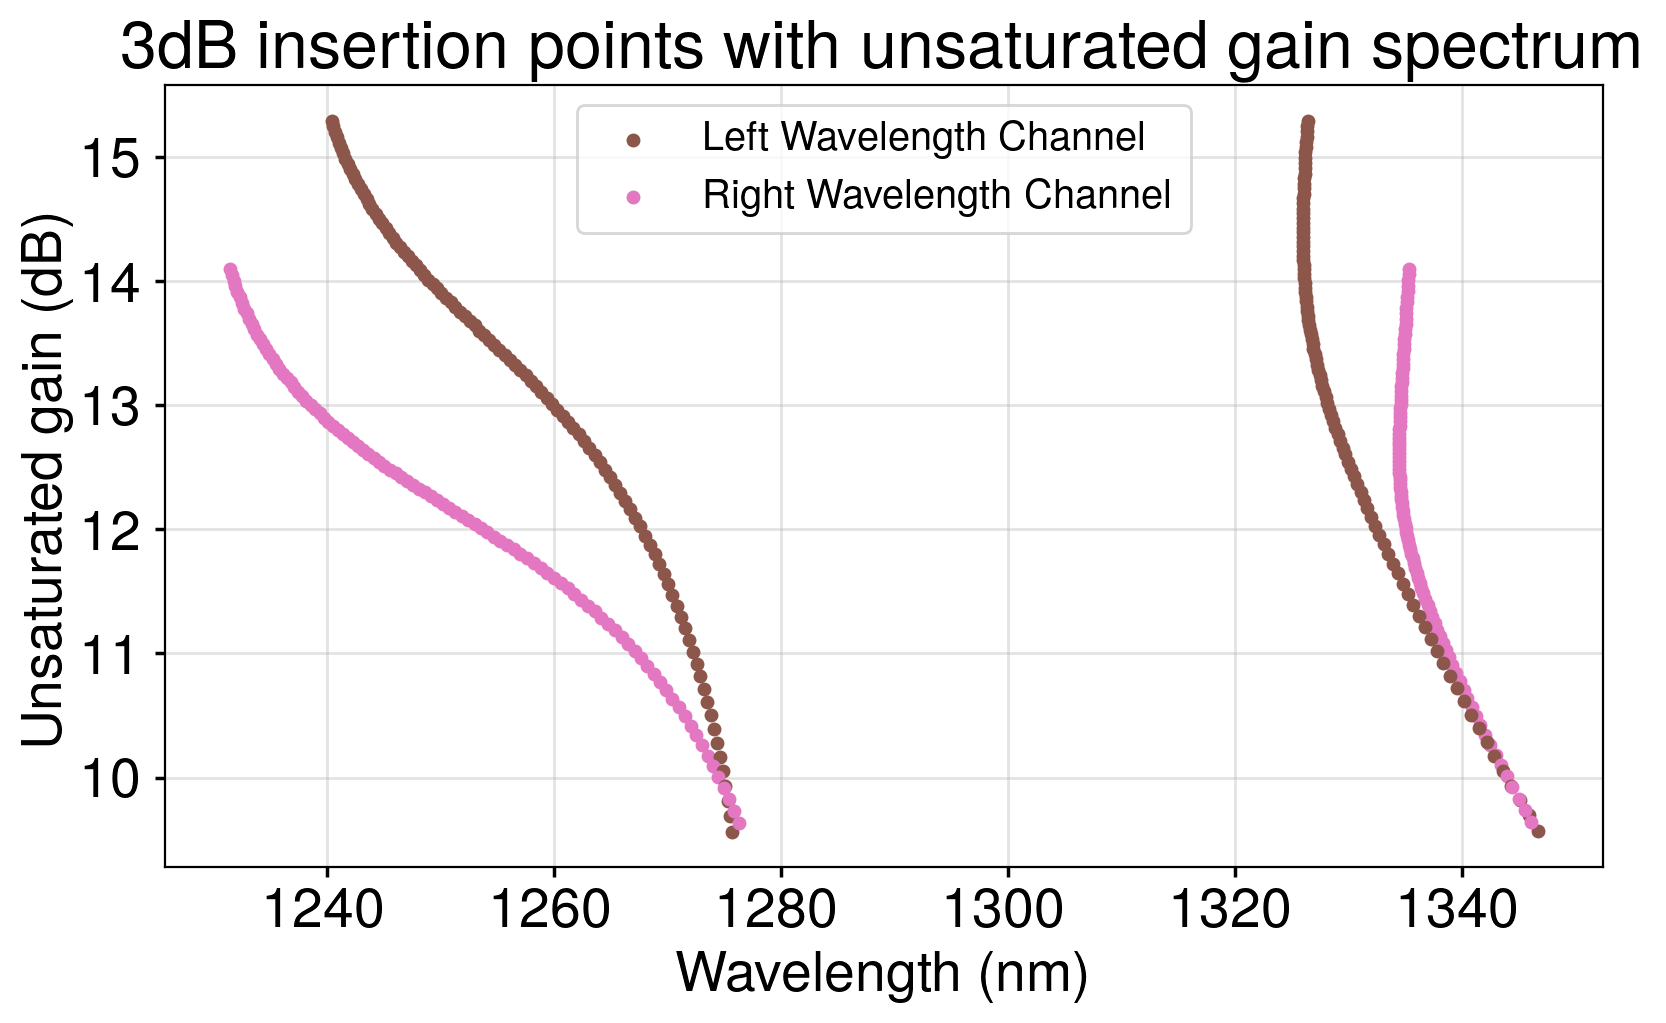

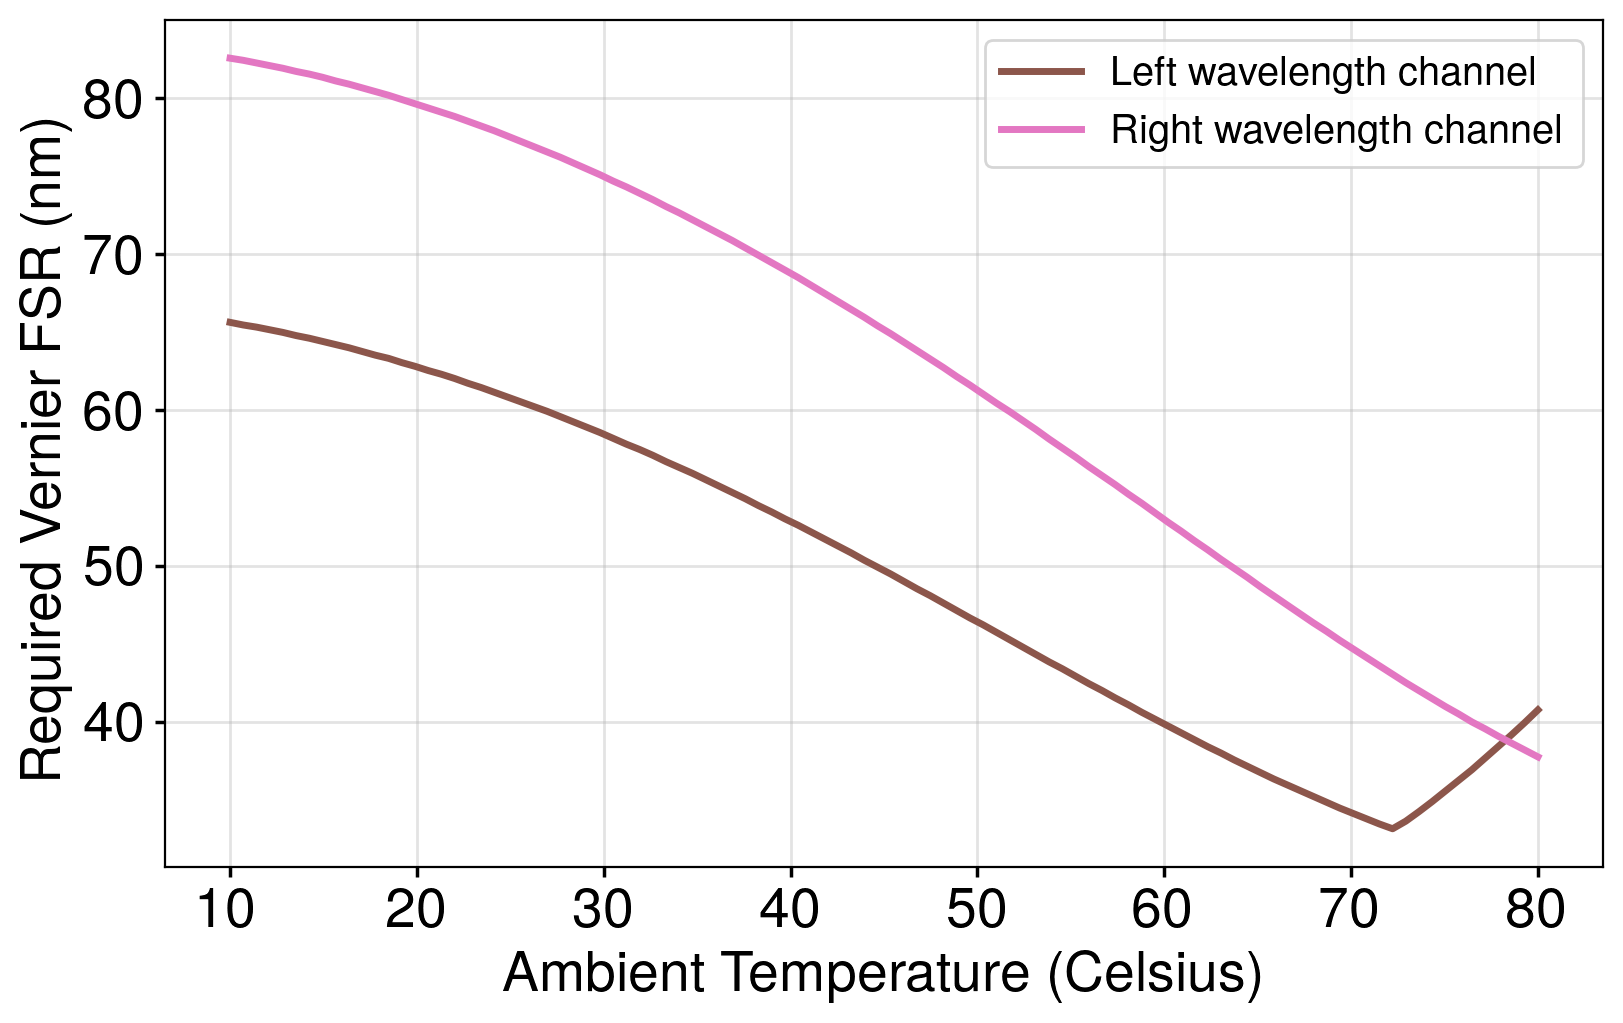

In [15]:
#SOA gain curve over our temperature range
L = 440
J = 7
T_sweep = [35,55,70,80]

import pandas as pd
from scipy.constants import c

largest_gain_seen = -1000

plt.figure()
lambda_sweep = np.linspace(1200,1370,num=5000)
for T_index,T in enumerate(T_sweep):
    g0_sweep = []
    for x in lambda_sweep:
        tmp = SOA(T,J,L,x)
        g0_sweep.append(tmp.g0)
        if 10*np.log10(tmp.g0) > largest_gain_seen:
            largest_gain_seen = 10*np.log10(tmp.g0)
    g0_sweep = np.array(g0_sweep)
    # g0_sweep = np.array([g0(x,T,J,L) for x in lambda_sweep])
    g0_sweep_dB = 10*np.log10(g0_sweep)
    plt.plot(lambda_sweep,g0_sweep_dB,c=f"C{T_index}",linewidth=1)
    print(f"T = {T}, lambda_peak = {tmp.wavelength_peak} (nm), FWHM = {tmp.FWHM} (nm), gpeak = {tmp.gain_peak} (dB)")

left_channel_vernier_FSR_storage = []
right_channel_vernier_FSR_storage = []
#Suppose we are lasing at 1310nm + 7*200GHz. I want to know what the worst case bandwidth I need to support is
for T in T_sweep:
    channel_spacing_Hz = 200e9
    center_wavelength = 1310e-9
    center_frequency = c/center_wavelength
    channel_spacing_meters = center_wavelength * channel_spacing_Hz/center_frequency

    left_most_channel = center_wavelength - 3.5 * channel_spacing_meters
    right_most_channel = center_wavelength + 3.5 * channel_spacing_meters

    left_most_channel_unsaturated_gain = SOA(T,J,L,left_most_channel*1e9).g0
    right_most_channel_unsaturated_gain = SOA(T,J,L,right_most_channel*1e9).g0

    g0_lambda_sweep_of_SOA = np.array([SOA(T,J,L,i).g0 for i in lambda_sweep])

    crossover_plot_left_channel = g0_lambda_sweep_of_SOA - left_most_channel_unsaturated_gain/2
    crossover_plot_right_channel = g0_lambda_sweep_of_SOA - right_most_channel_unsaturated_gain/2
    left_most_channel_3dB_intersections_index = np.where(np.diff(np.sign(crossover_plot_left_channel)))[0]
    right_most_channel_3dB_intersections_index = np.where(np.diff(np.sign(crossover_plot_right_channel)))[0]

    left_most_channel_required_FSR_nm = max(
        np.abs(lambda_sweep[left_most_channel_3dB_intersections_index][0] - left_most_channel*1e9),
        np.abs(lambda_sweep[left_most_channel_3dB_intersections_index][1] - left_most_channel*1e9),
    )
    right_most_channel_required_FSR_nm = max(
        np.abs(lambda_sweep[right_most_channel_3dB_intersections_index][0] - right_most_channel*1e9),
        np.abs(lambda_sweep[right_most_channel_3dB_intersections_index][1] - right_most_channel*1e9),
    )

    print(f"T = {T}, left channel required Vernier FSR (nm): {left_most_channel_required_FSR_nm}")
    print(f"T = {T}, right channel required Vernier FSR (nm): {right_most_channel_required_FSR_nm}")

    plt.scatter(lambda_sweep[left_most_channel_3dB_intersections_index],10*np.log10(g0_lambda_sweep_of_SOA[left_most_channel_3dB_intersections_index]),s=16,zorder=10, c='C5')
    plt.scatter(lambda_sweep[right_most_channel_3dB_intersections_index],10*np.log10(g0_lambda_sweep_of_SOA[right_most_channel_3dB_intersections_index]),s=16,zorder=10, c='C6')

    left_channel_vernier_FSR_storage.append(left_most_channel_required_FSR_nm)
    right_channel_vernier_FSR_storage.append(right_most_channel_required_FSR_nm)

left_channel_vernier_FSR_storage = np.array(left_channel_vernier_FSR_storage)
right_channel_vernier_FSR_storage = np.array(right_channel_vernier_FSR_storage)

plt.vlines(left_most_channel*1e9,ymin = np.min(g0_sweep_dB),ymax=largest_gain_seen,color='C5',linestyle='--')
plt.vlines(right_most_channel*1e9,ymin = np.min(g0_sweep_dB),ymax=largest_gain_seen,color='C6',linestyle='--')

plt.legend([str(i) +  r" $^{\circ} \rm{C}$" for i in T_sweep])
plt.xlabel("Wavelength (nm)")
plt.ylabel("g0 (dB)")
plt.title("SOA Unsaturated Gain vs Wavelength and Temperature")
plt.show()

T_sweep = np.linspace(10,80,num=100)
plt.figure()
left_channel_vernier_FSR_storage = []
right_channel_vernier_FSR_storage = []
#Suppose we are lasing at 1310nm + 7*200GHz. I want to know what the worst case bandwidth I need to support is
for T in tqdm(T_sweep,desc='temperature sweep'):
    channel_spacing_Hz = 200e9
    center_wavelength = 1310e-9
    center_frequency = c/center_wavelength
    channel_spacing_meters = center_wavelength * channel_spacing_Hz/center_frequency

    left_most_channel = center_wavelength - 3.5 * channel_spacing_meters
    right_most_channel = center_wavelength + 3.5 * channel_spacing_meters

    left_most_channel_unsaturated_gain = SOA(T,J,L,left_most_channel*1e9).g0
    right_most_channel_unsaturated_gain = SOA(T,J,L,right_most_channel*1e9).g0

    g0_lambda_sweep_of_SOA = np.array([SOA(T,J,L,i).g0 for i in lambda_sweep])

    crossover_plot_left_channel = g0_lambda_sweep_of_SOA - left_most_channel_unsaturated_gain/2
    crossover_plot_right_channel = g0_lambda_sweep_of_SOA - right_most_channel_unsaturated_gain/2
    left_most_channel_3dB_intersections_index = np.where(np.diff(np.sign(crossover_plot_left_channel)))[0]
    right_most_channel_3dB_intersections_index = np.where(np.diff(np.sign(crossover_plot_right_channel)))[0]

    left_most_channel_required_FSR_nm = max(
        np.abs(lambda_sweep[left_most_channel_3dB_intersections_index][0] - left_most_channel*1e9),
        np.abs(lambda_sweep[left_most_channel_3dB_intersections_index][1] - left_most_channel*1e9),
    )
    right_most_channel_required_FSR_nm = max(
        np.abs(lambda_sweep[right_most_channel_3dB_intersections_index][0] - right_most_channel*1e9),
        np.abs(lambda_sweep[right_most_channel_3dB_intersections_index][1] - right_most_channel*1e9),
    )

    plt.scatter(lambda_sweep[left_most_channel_3dB_intersections_index],10*np.log10(g0_lambda_sweep_of_SOA[left_most_channel_3dB_intersections_index]),s=16,zorder=10, c='C5')
    plt.scatter(lambda_sweep[right_most_channel_3dB_intersections_index],10*np.log10(g0_lambda_sweep_of_SOA[right_most_channel_3dB_intersections_index]),s=16,zorder=10, c='C6')

    left_channel_vernier_FSR_storage.append(left_most_channel_required_FSR_nm)
    right_channel_vernier_FSR_storage.append(right_most_channel_required_FSR_nm)

left_channel_vernier_FSR_storage = np.array(left_channel_vernier_FSR_storage)
right_channel_vernier_FSR_storage = np.array(right_channel_vernier_FSR_storage)

plt.title("3dB insertion points with unsaturated gain spectrum")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Unsaturated gain (dB)")
plt.legend(["Left Wavelength Channel","Right Wavelength Channel"])
plt.show()


plt.figure()
plt.plot(T_sweep,left_channel_vernier_FSR_storage, c='C5')
plt.plot(T_sweep,right_channel_vernier_FSR_storage, c='C6')
plt.xlabel("Ambient Temperature (Celsius)")
plt.ylabel("Required Vernier FSR (nm)")
plt.legend(["Left wavelength channel", "Right wavelength channel"])